In [3]:
import numpy as np
import pandas as pd

import sys
import datetime
import time
import math

import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [34]:
start_time = time.time()
# Pandas setting to display more dataset rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

sample_submission = pd.read_csv('./submission.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
origin = pd.read_csv('./mixed_desc.csv')

In [9]:
feat_ary = train.columns.drop('id')
feat_ary_2 = test.columns.drop('id')
feat_ary_3 = np.array(feat_ary_2)
feat_ary_3 = np.append(feat_ary_3, 'EC1')
origin[['EC1','EC2','EC3','EC4','EC5','EC6']] = origin['EC1_EC2_EC3_EC4_EC5_EC6'].str.split('_', expand=True).apply(lambda x: [int(i) for i in x])
origin = origin[feat_ary]
data_t_o = pd.concat([train, origin], ignore_index=True)
data_t_o = data_t_o.drop_duplicates()
data_all = pd.concat([data_t_o, test], ignore_index=True)


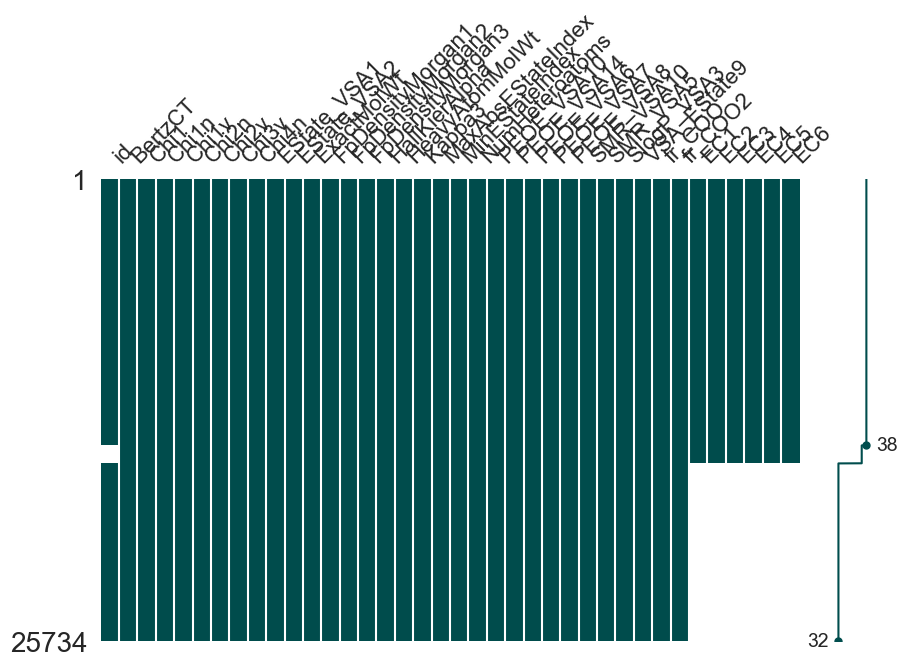

In [37]:
msno.matrix(df=data_all, figsize=(10,6), color=(0,.3,.3))
data_all[feat_ary].describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

In [38]:
train = data_all.iloc[data_t_o.index[0]:data_t_o.index[-1]+1-36]
test = data_all.iloc[data_t_o.index[-1]+1-36:]

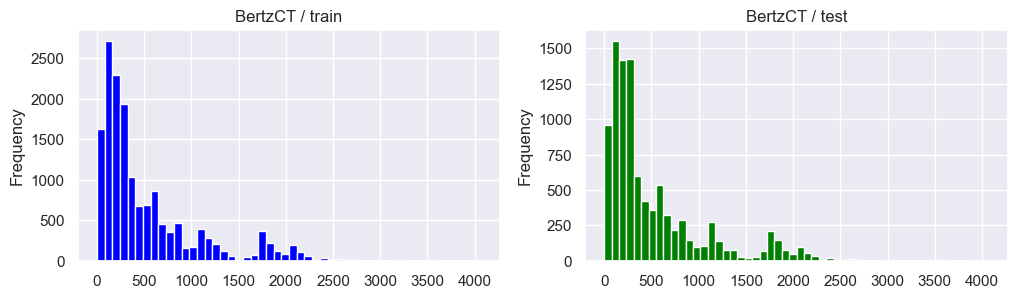

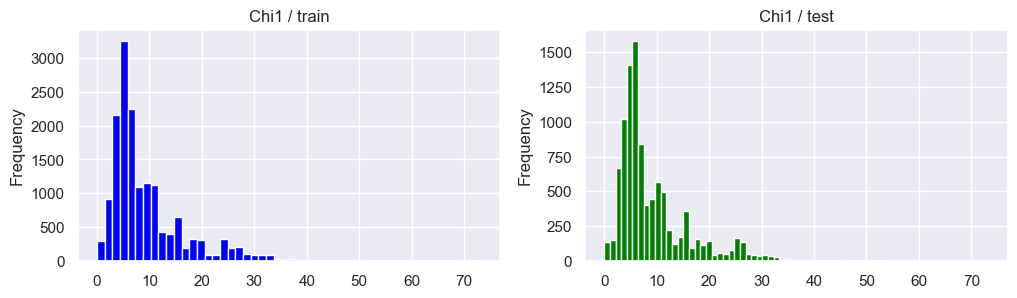

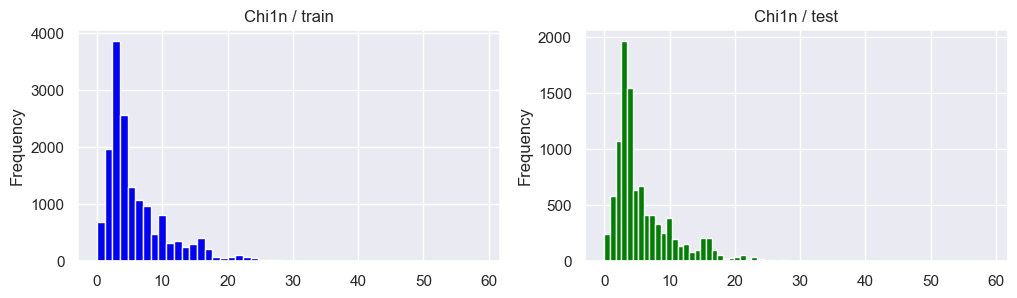

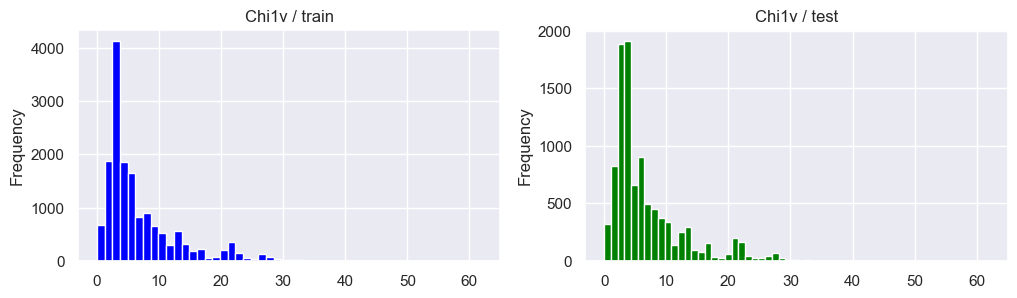

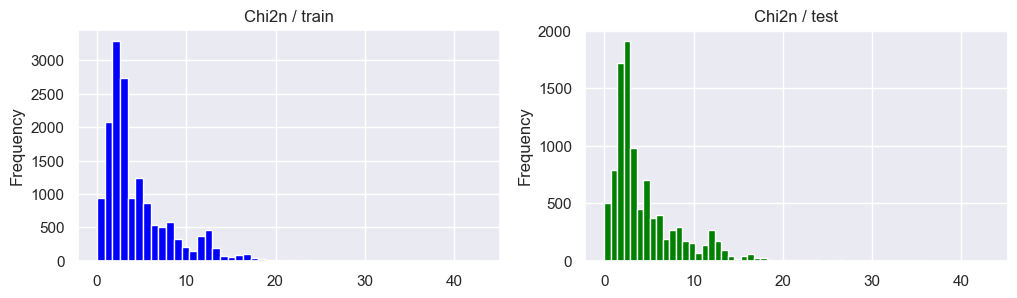

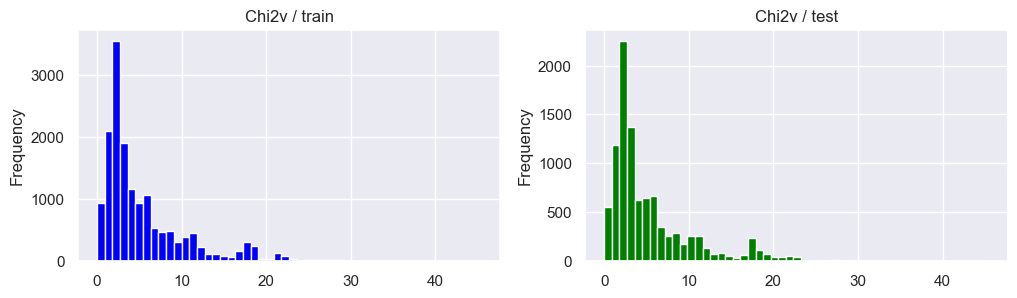

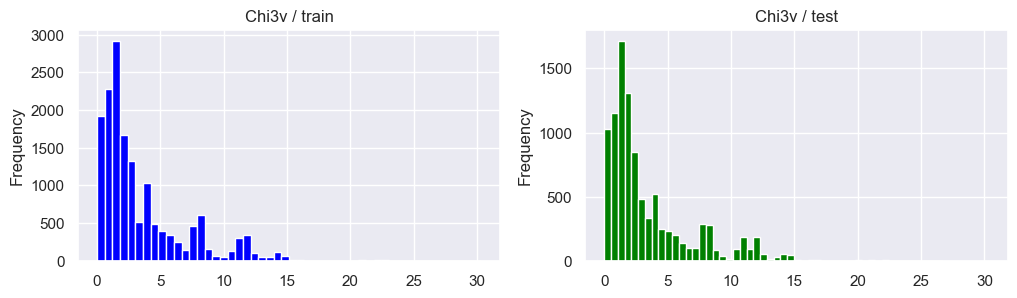

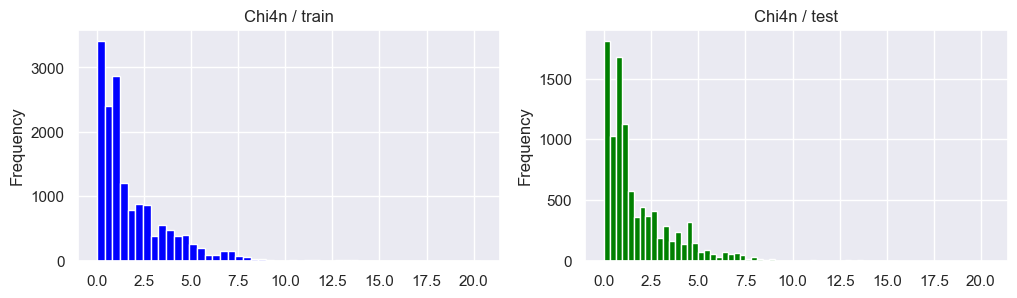

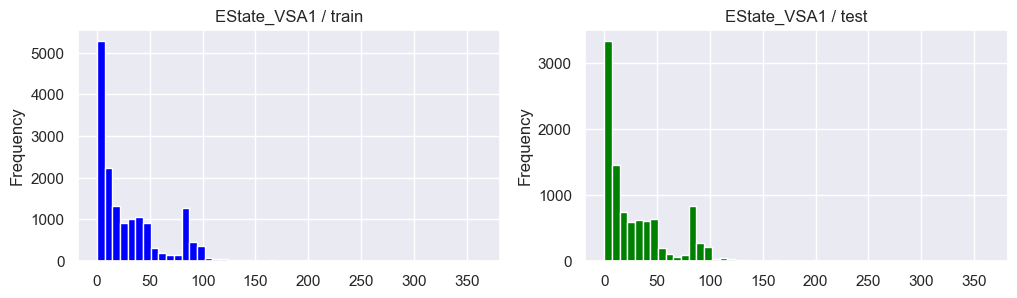

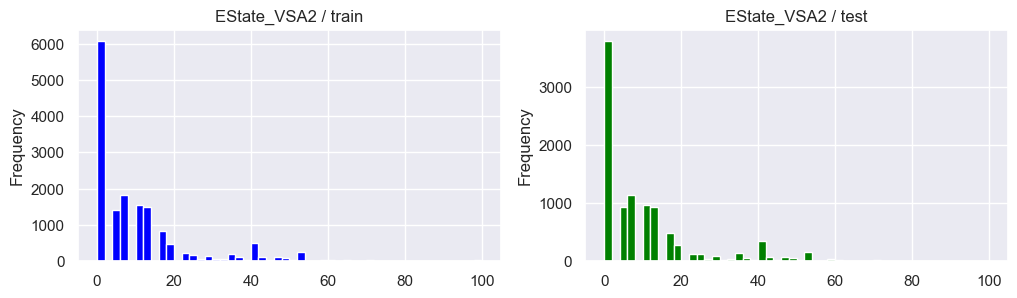

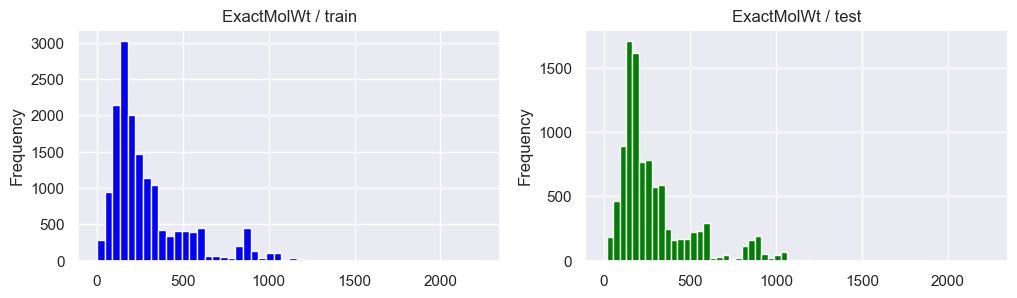

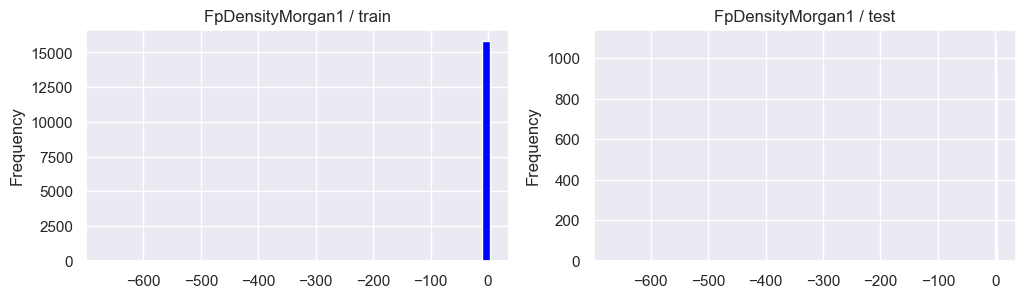

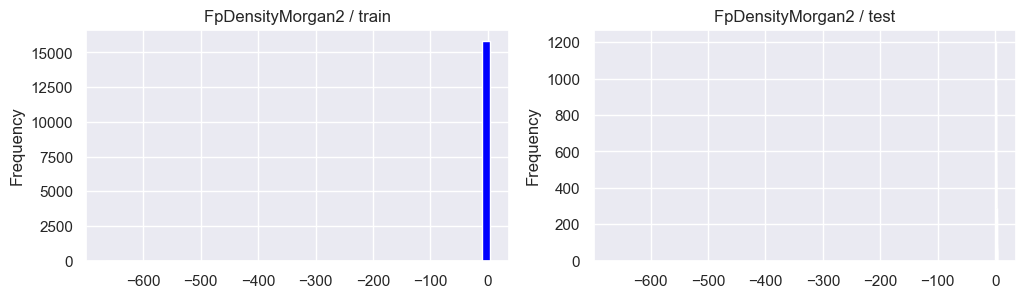

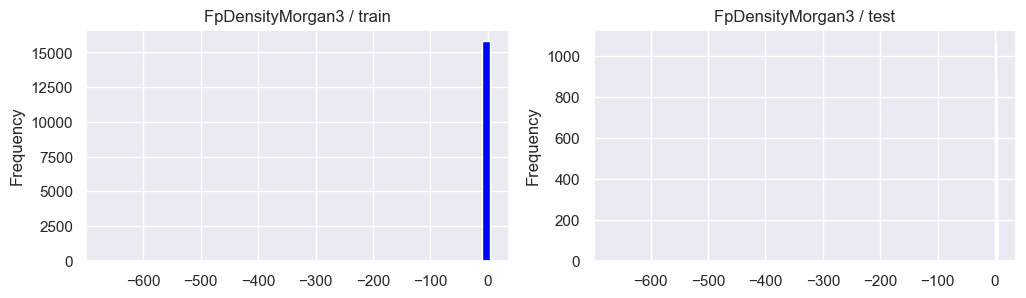

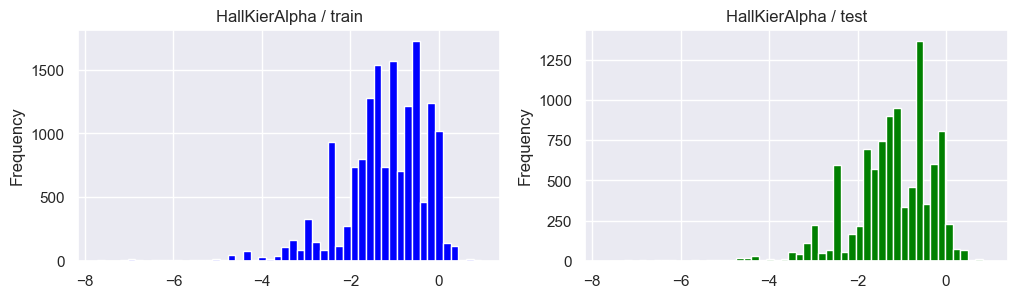

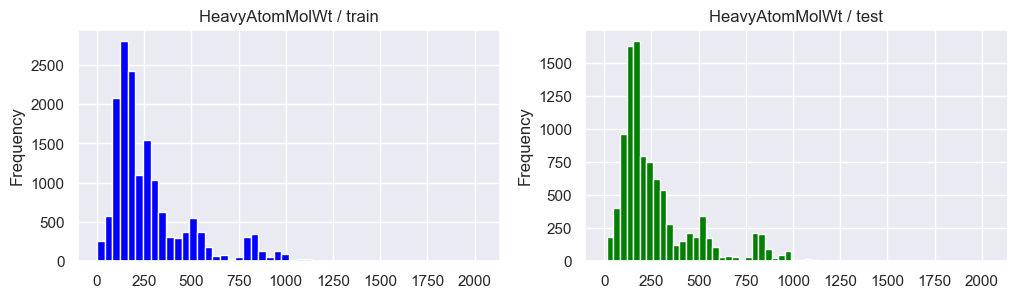

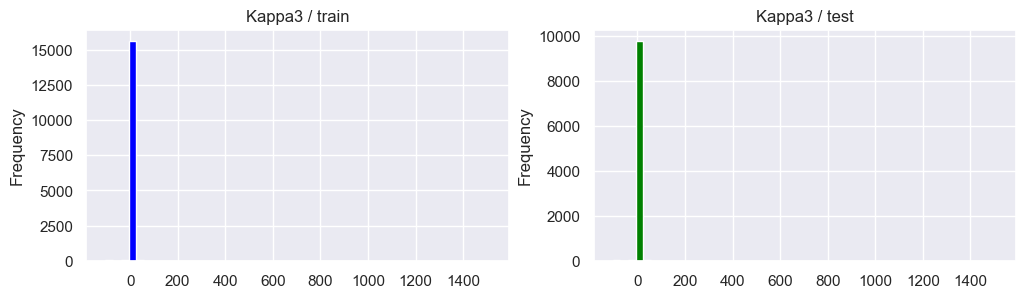

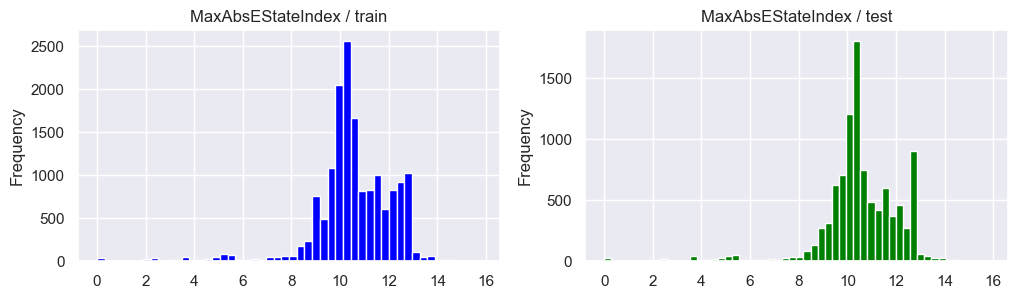

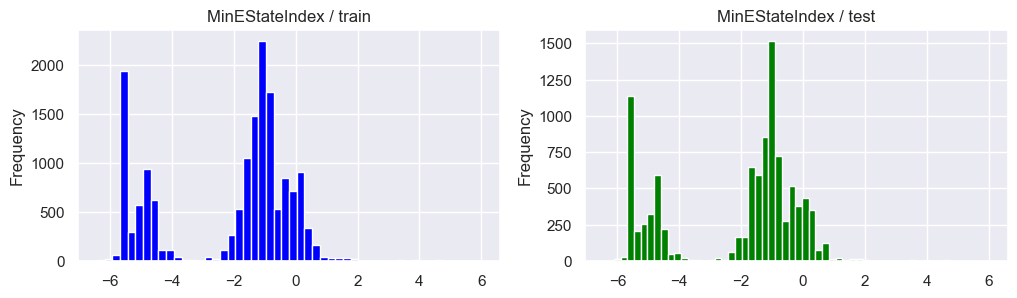

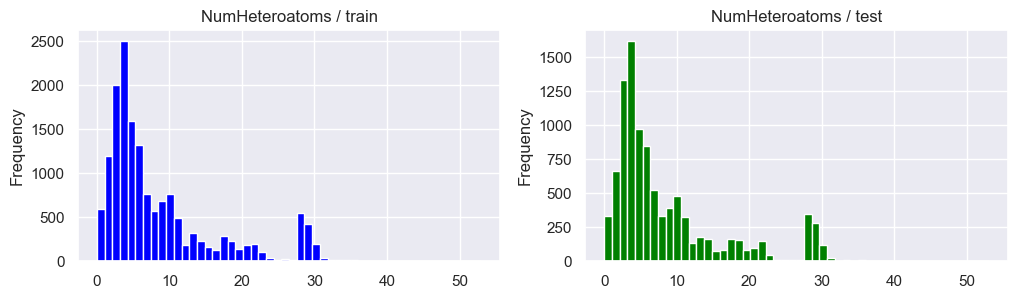

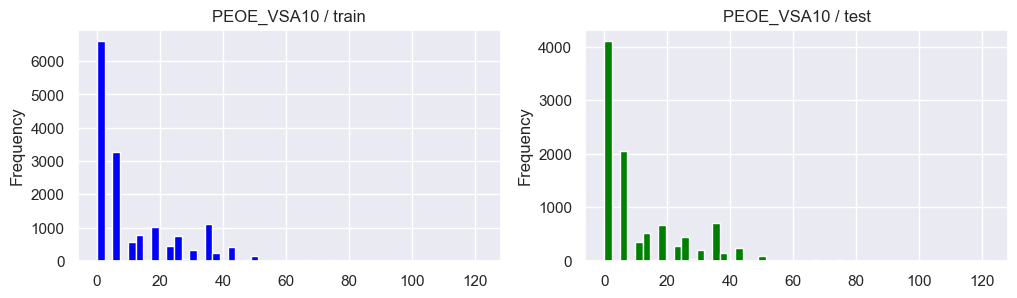

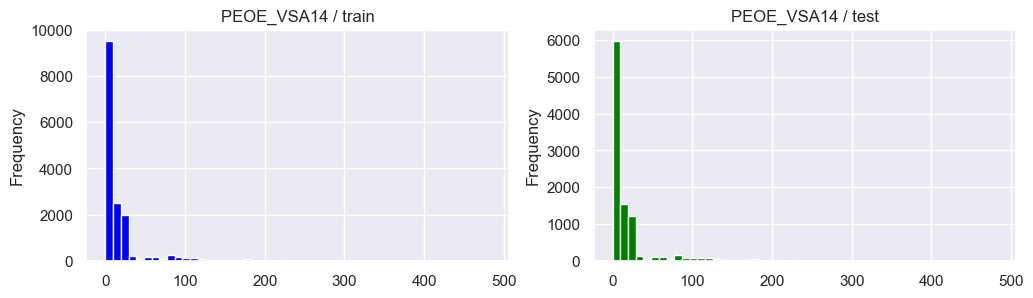

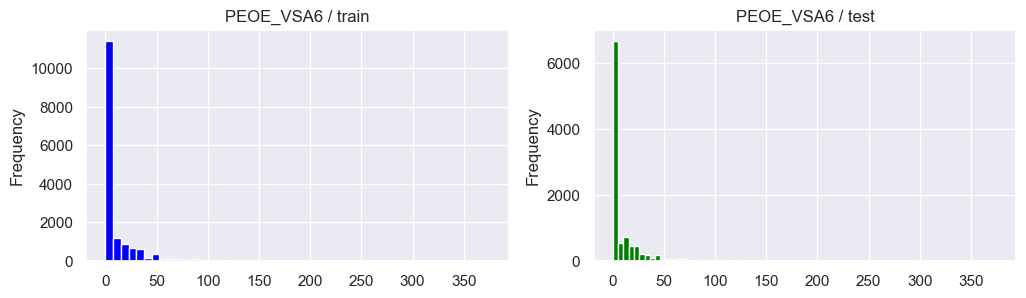

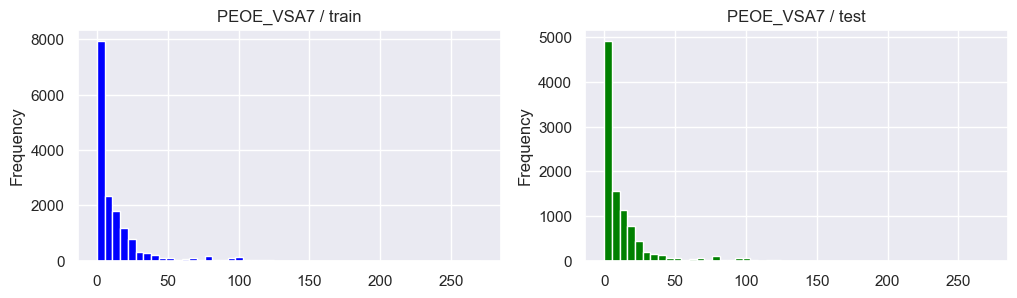

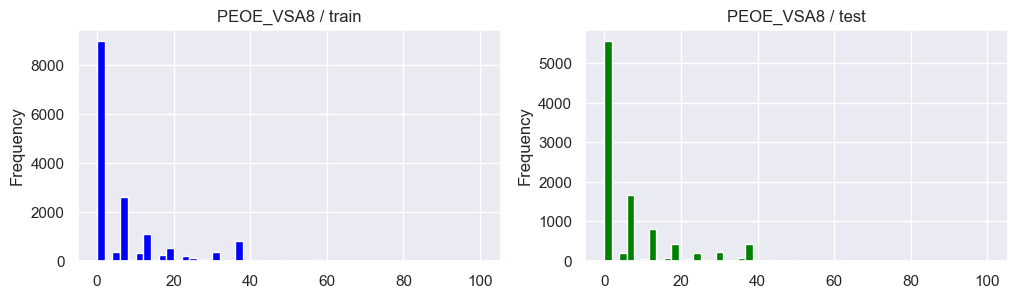

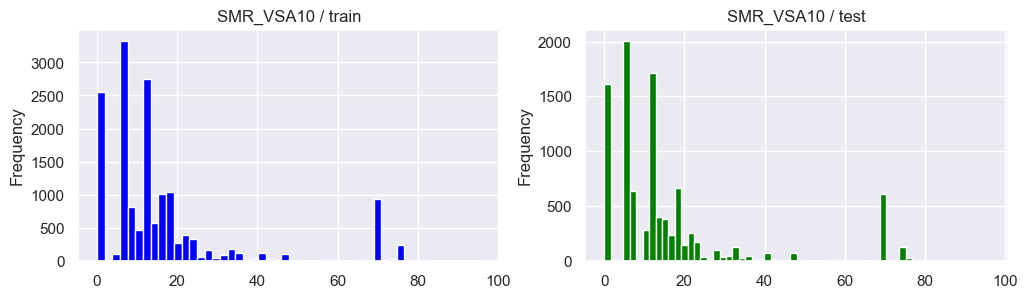

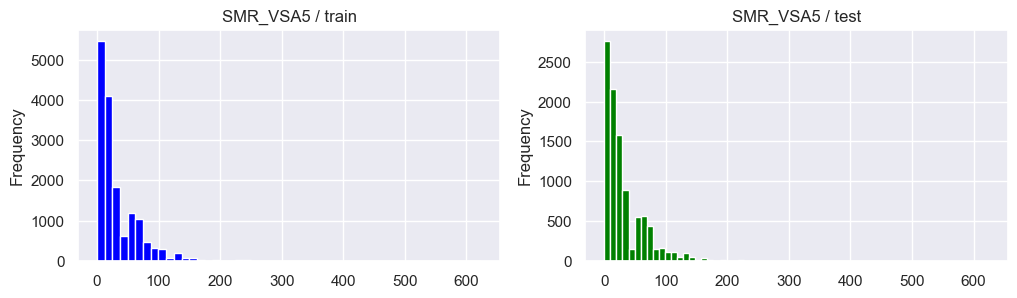

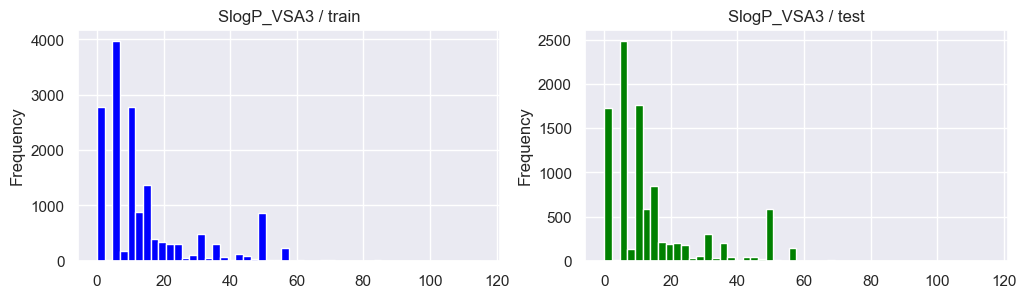

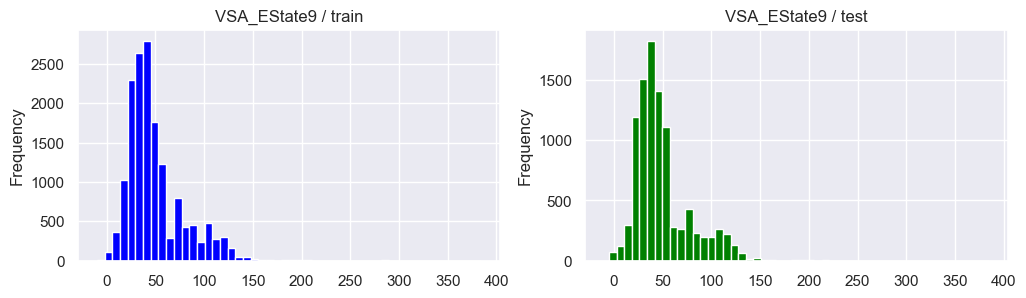

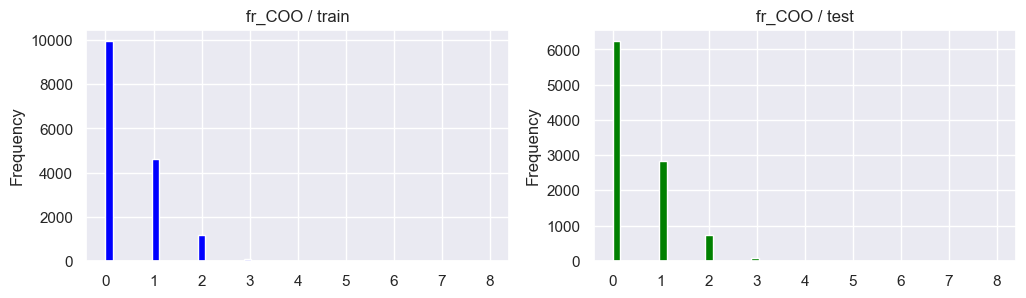

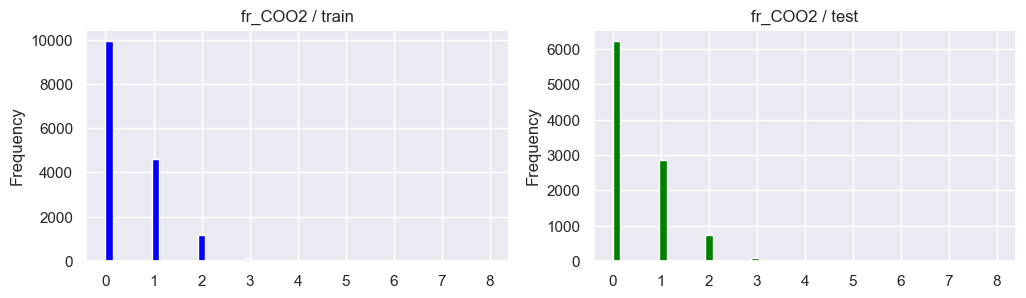

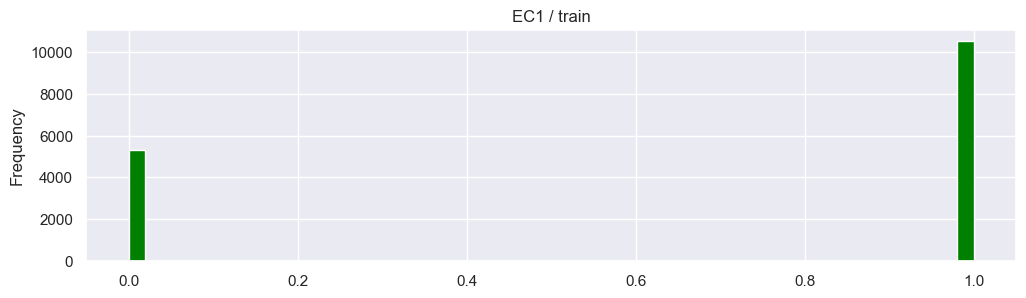

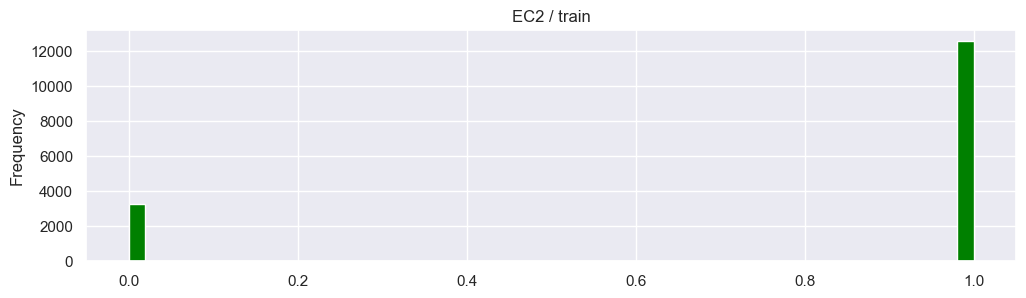

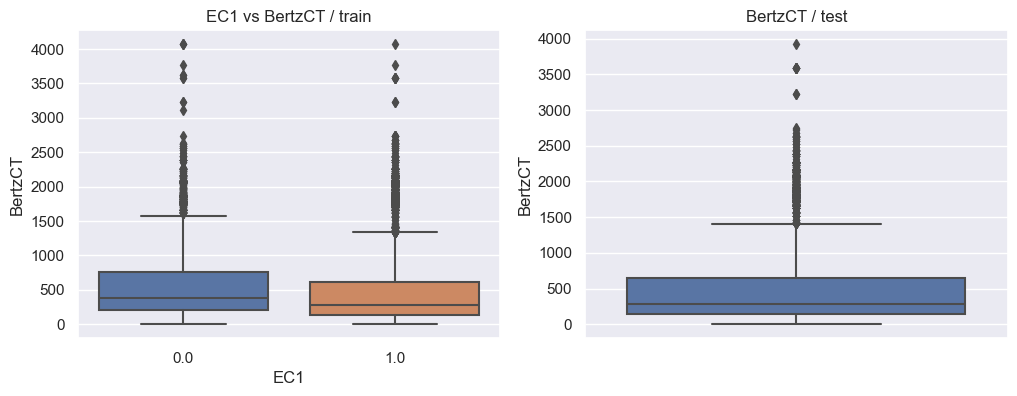

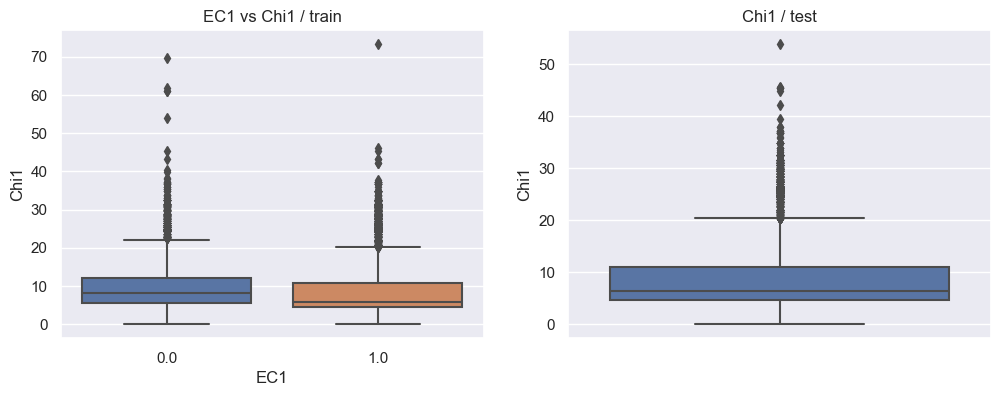

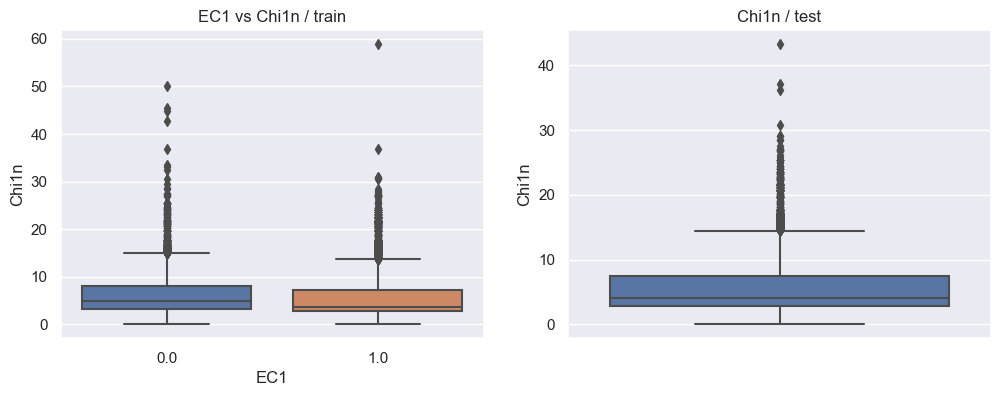

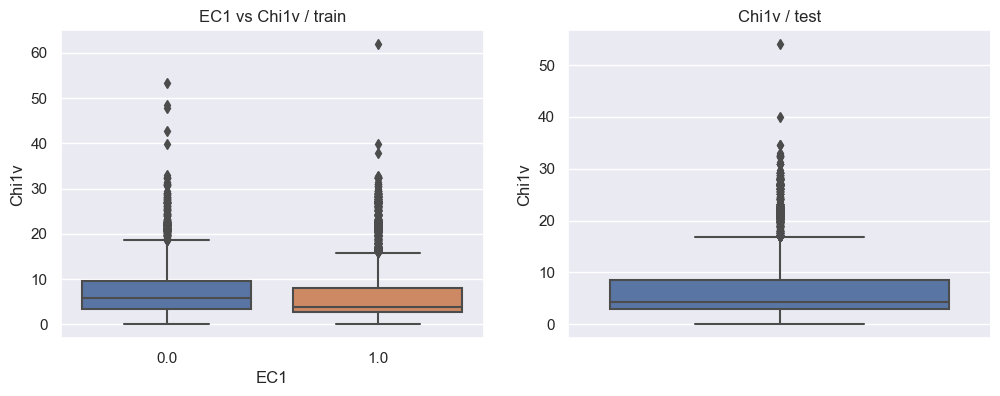

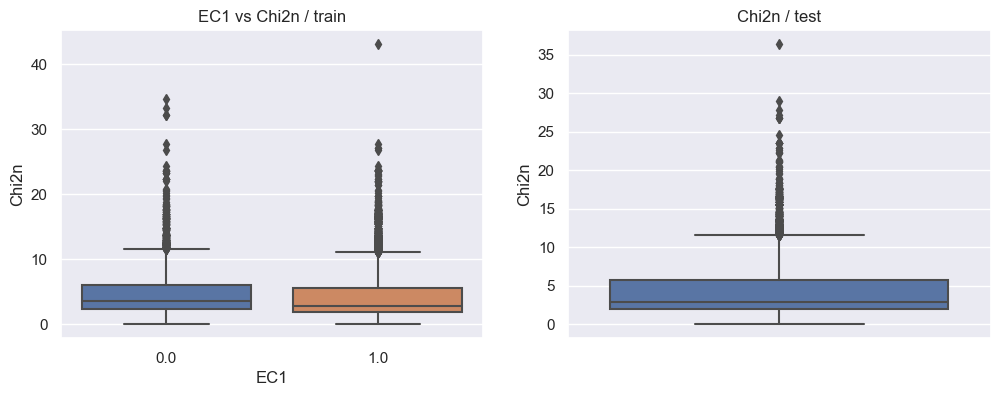

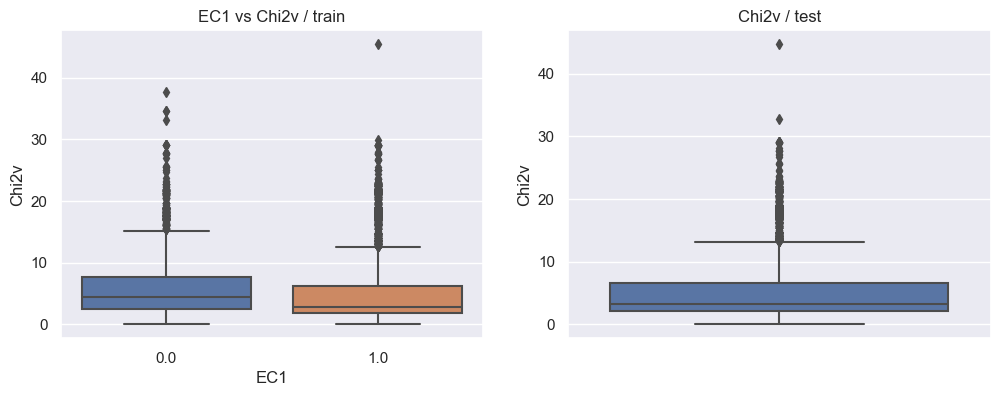

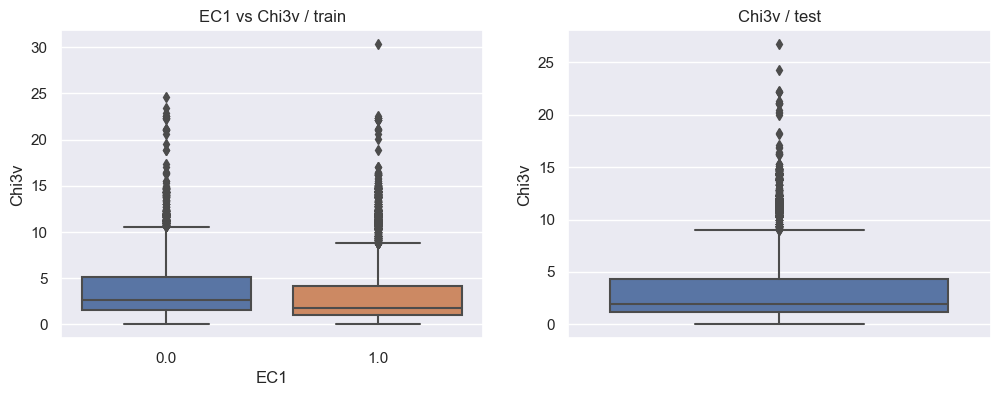

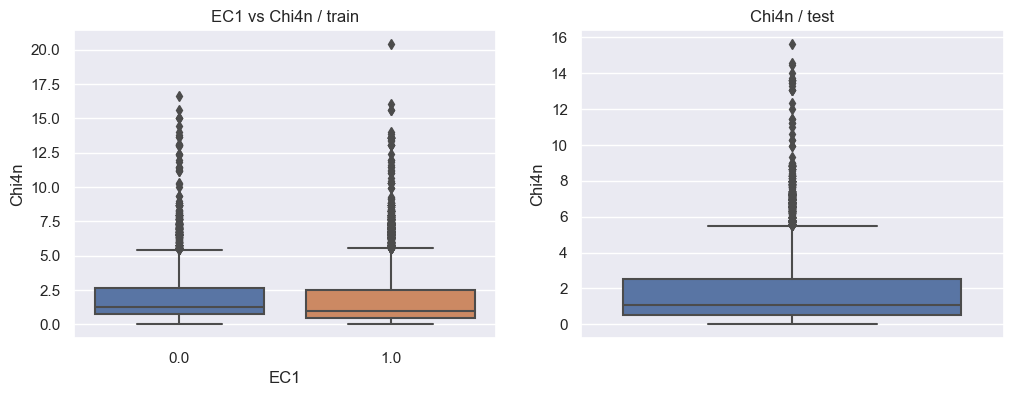

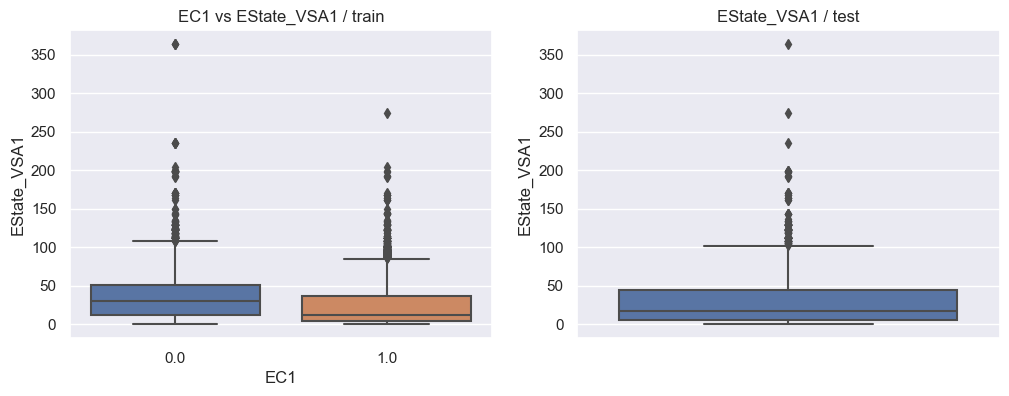

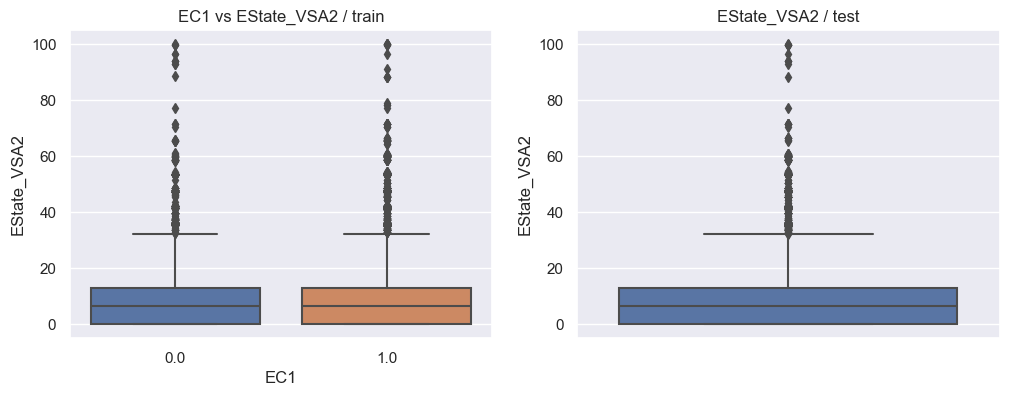

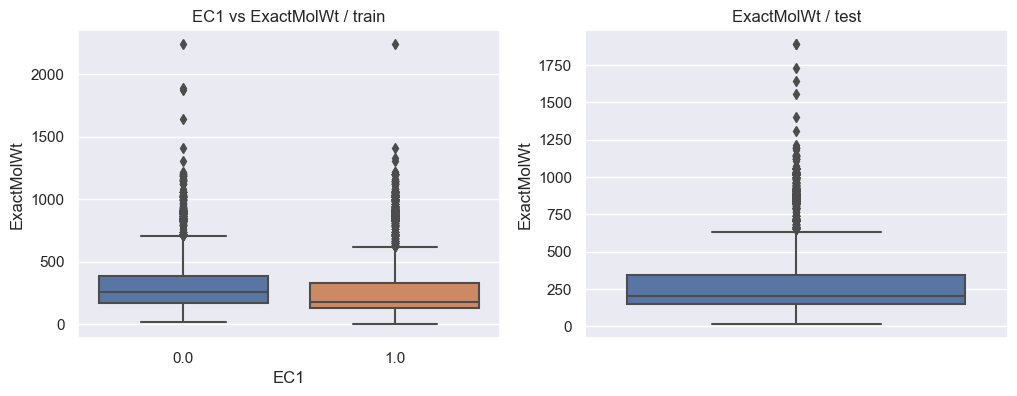

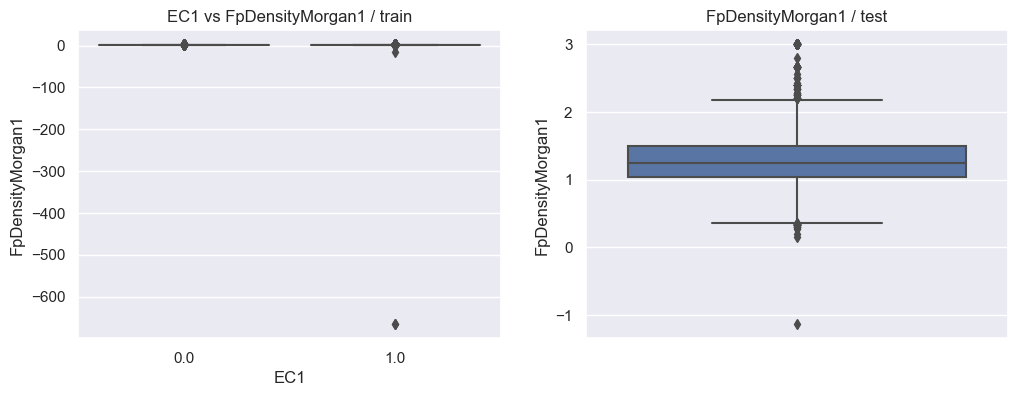

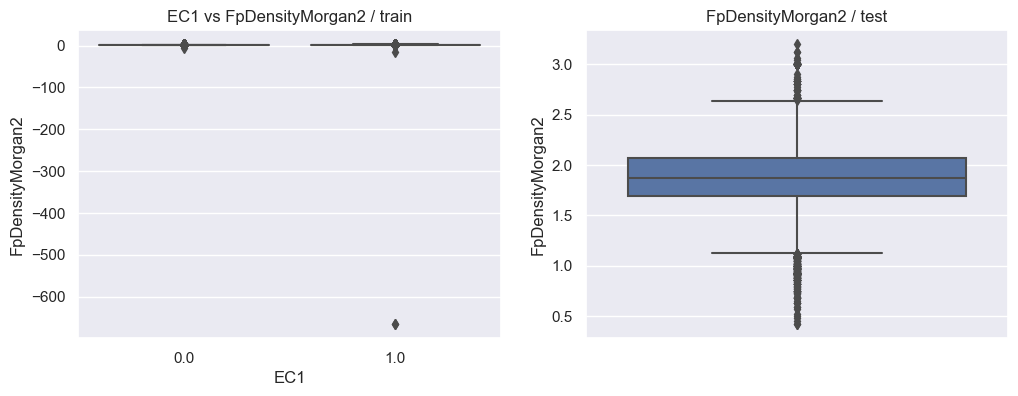

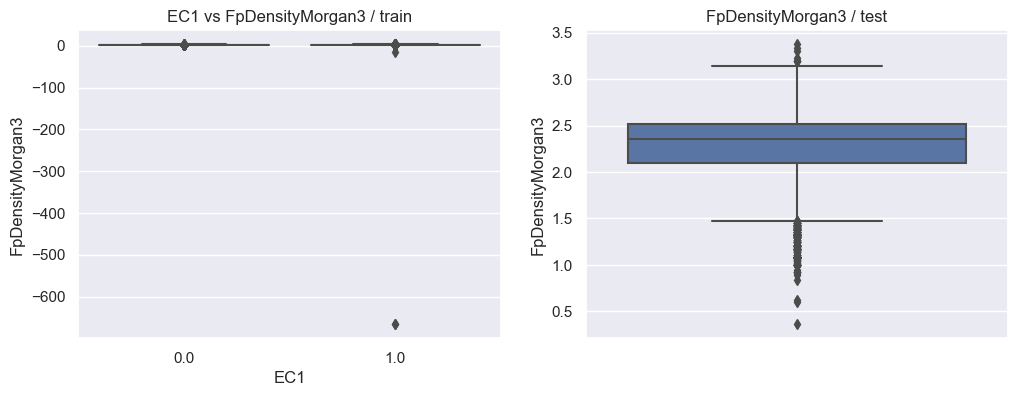

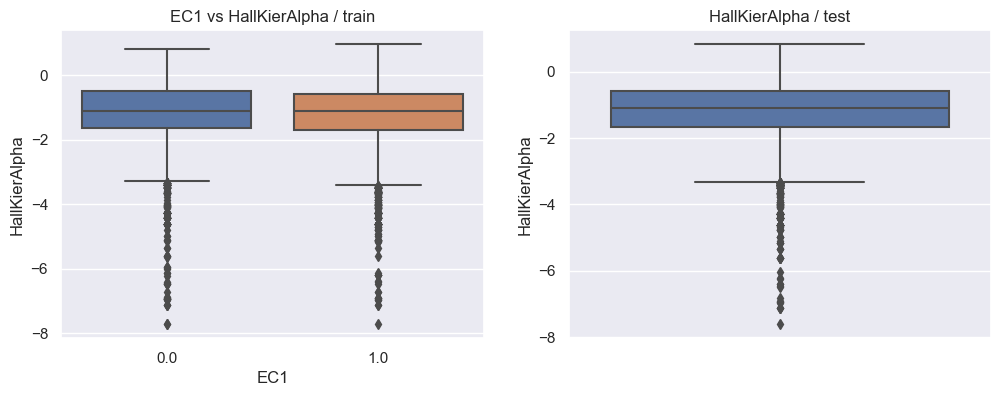

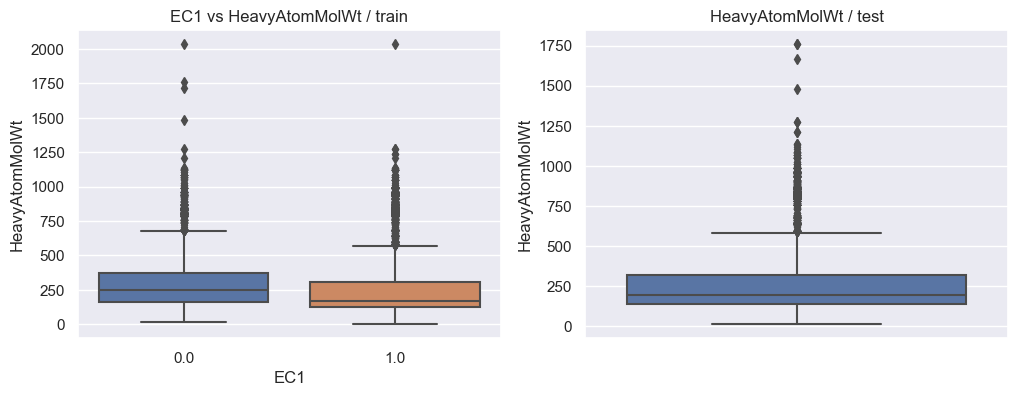

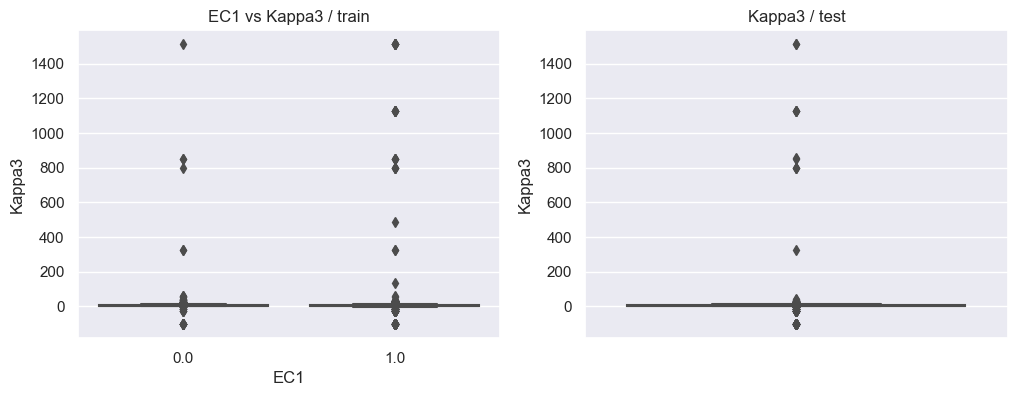

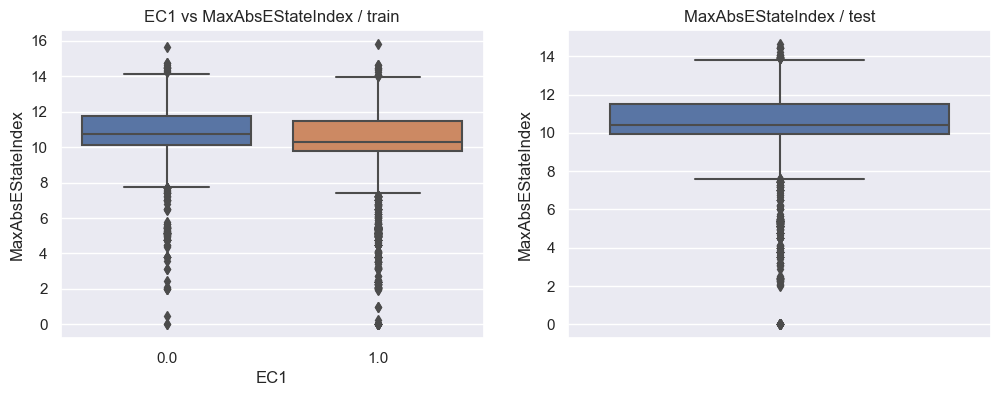

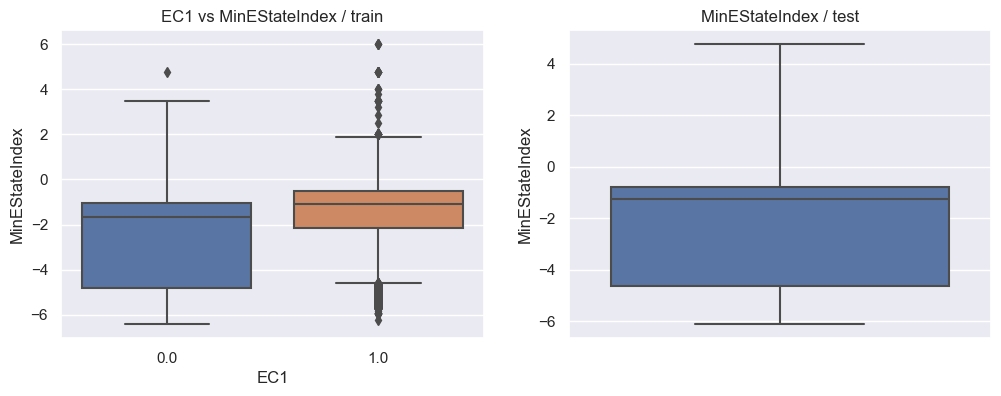

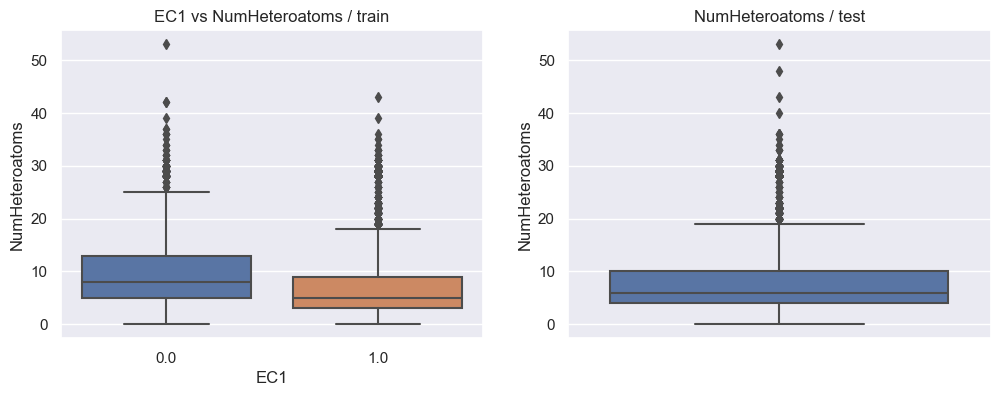

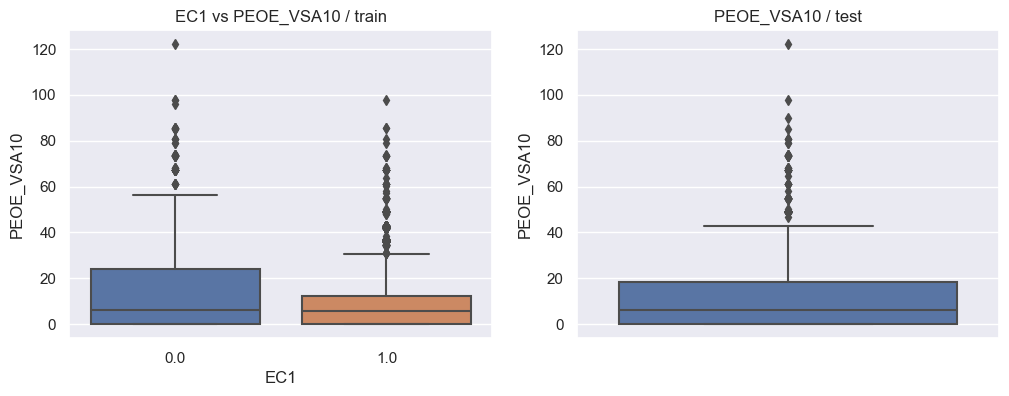

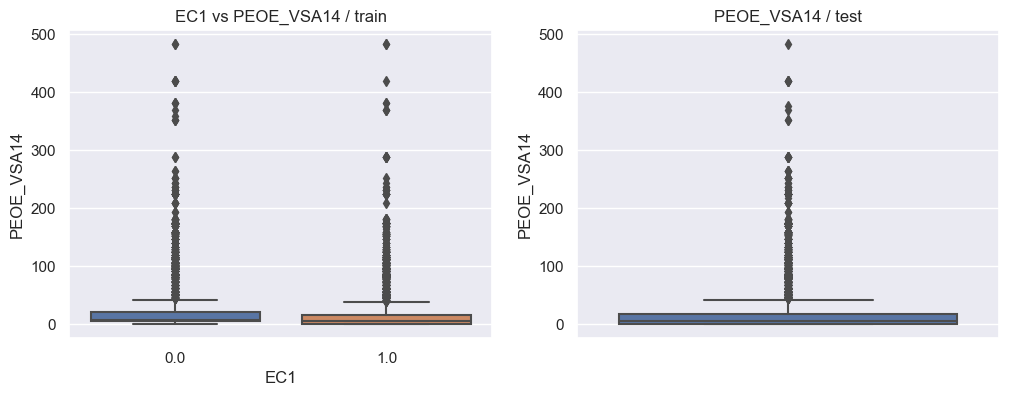

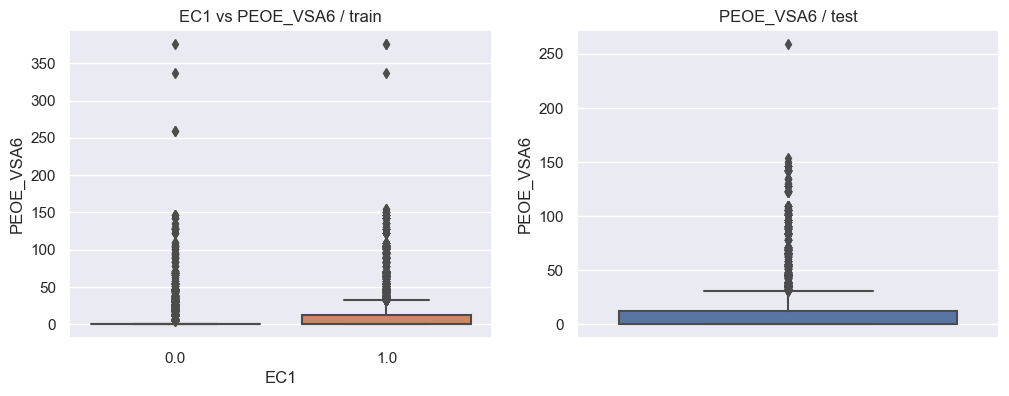

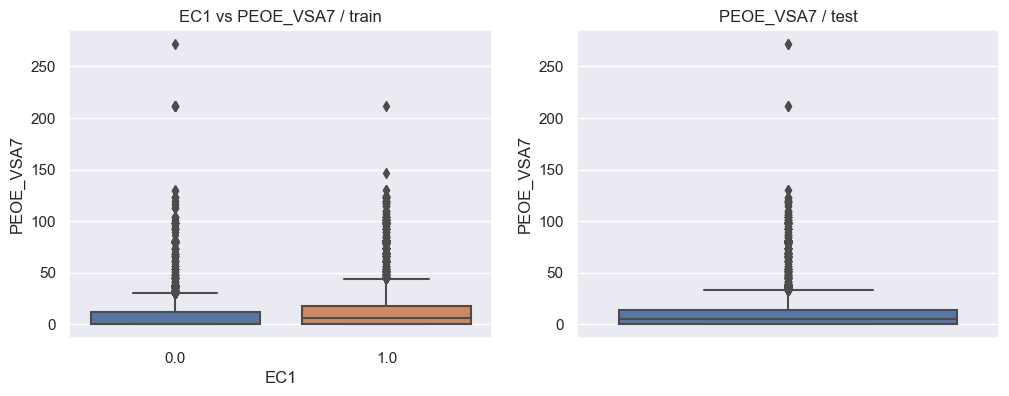

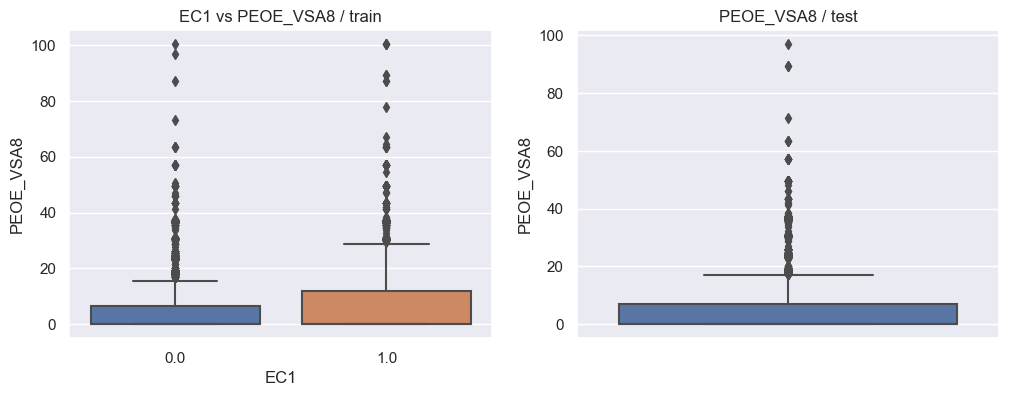

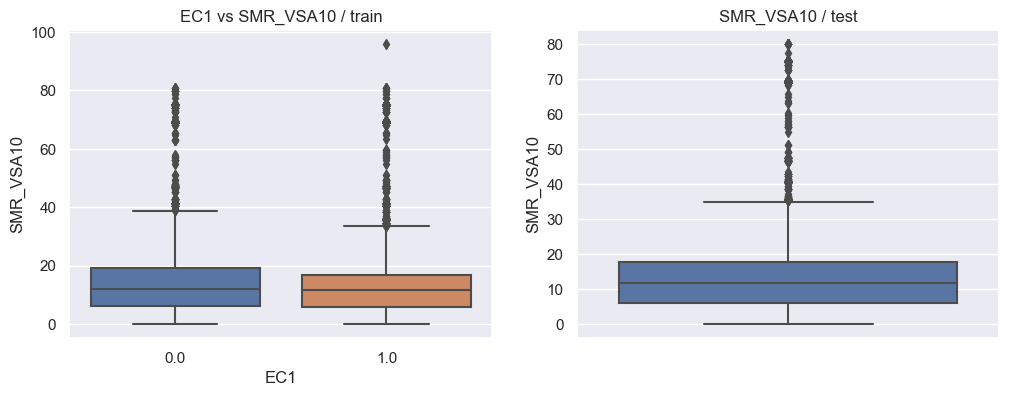

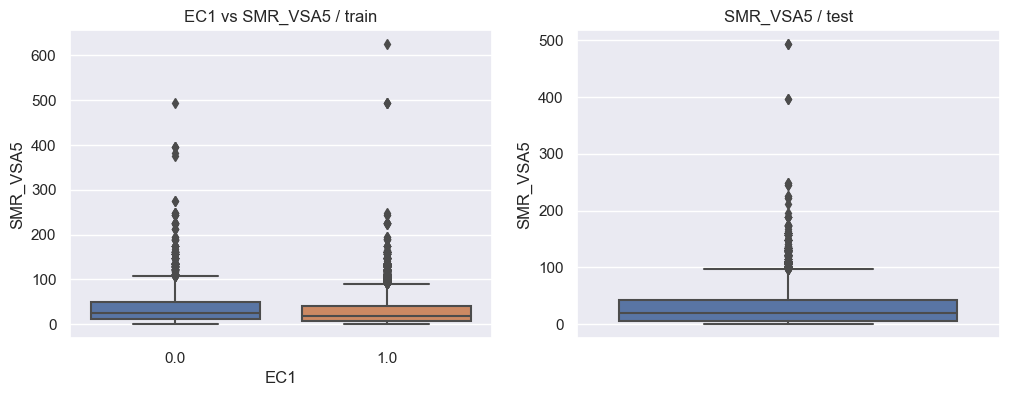

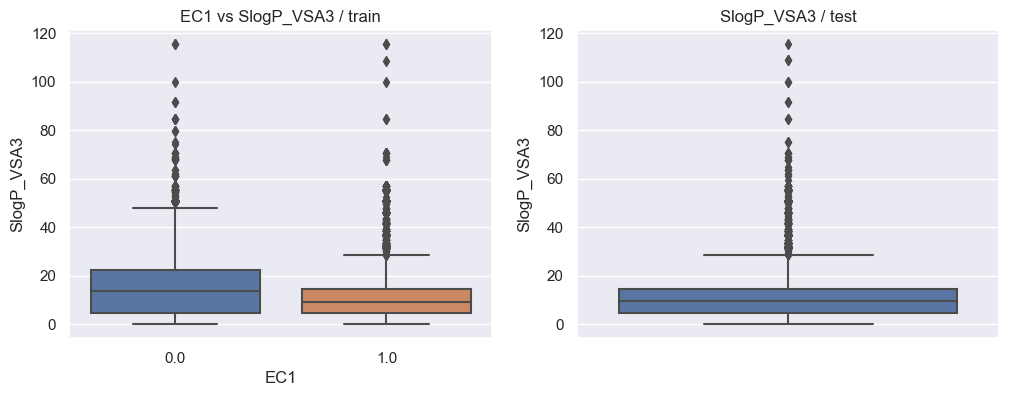

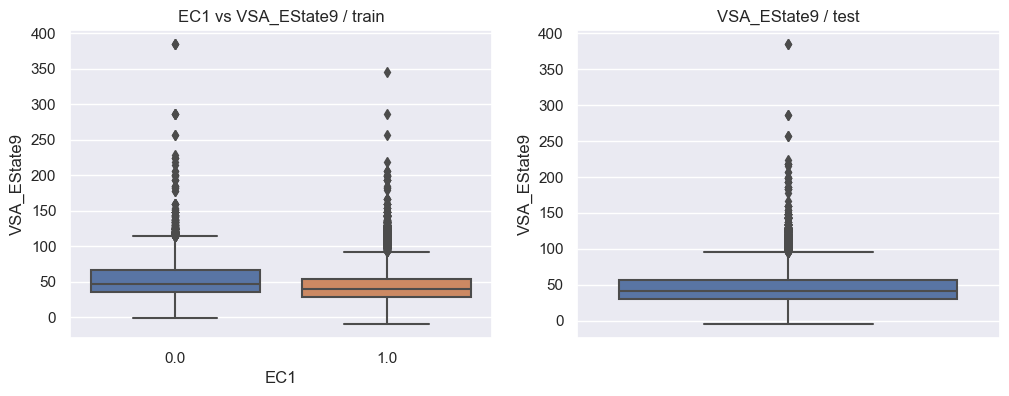

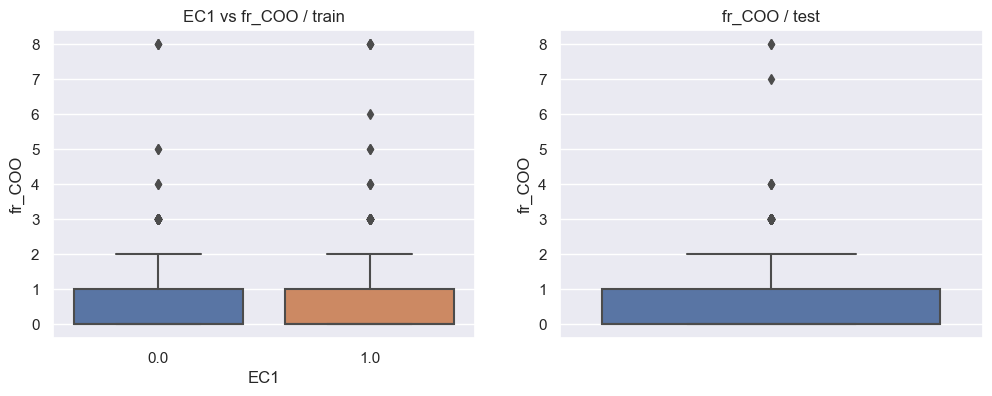

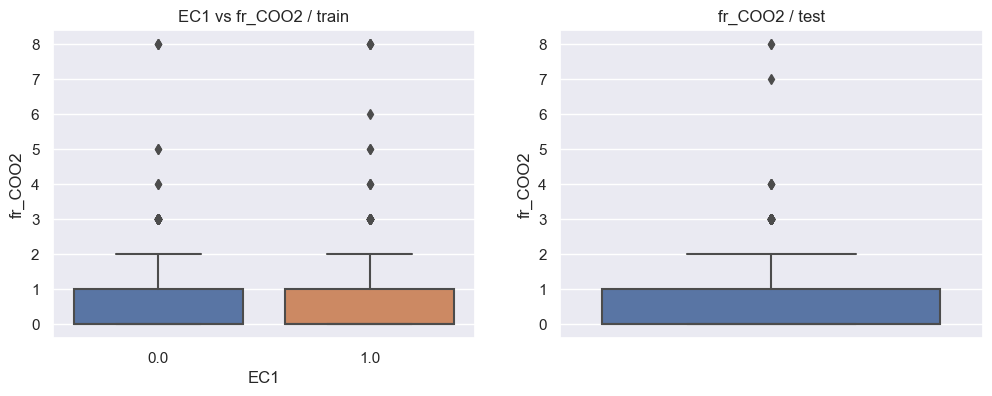

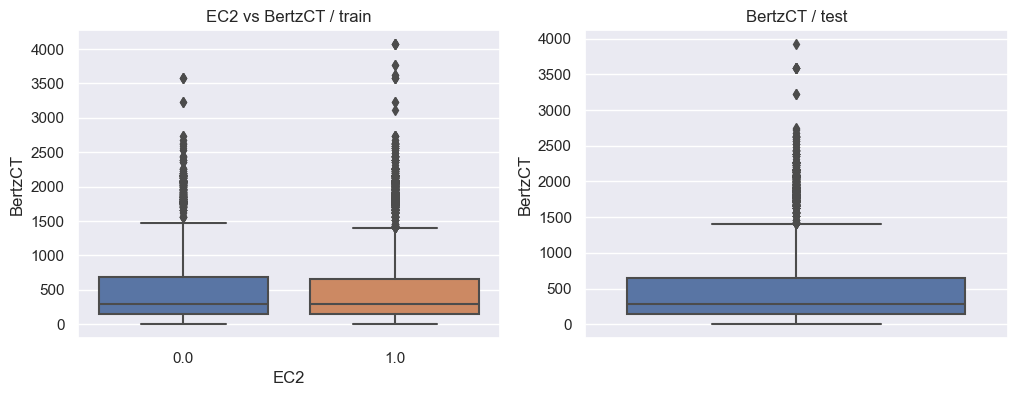

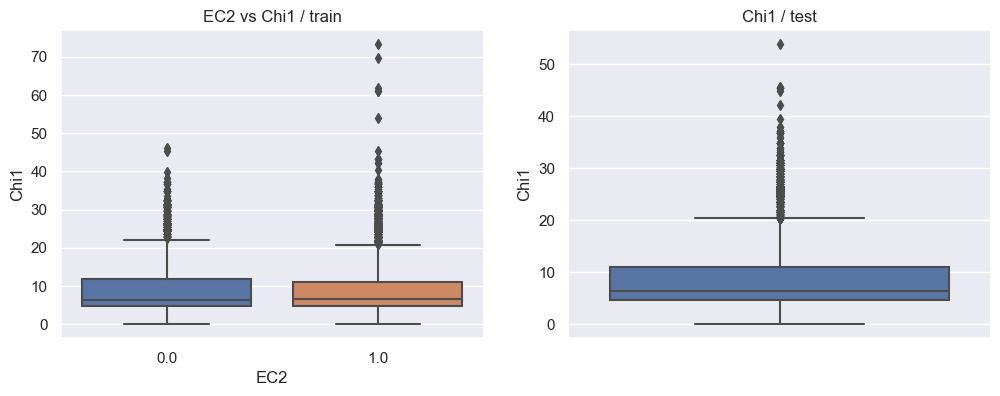

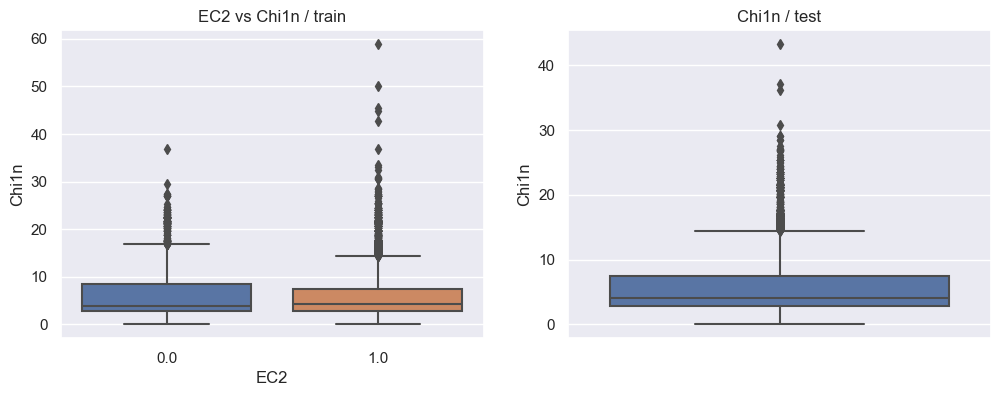

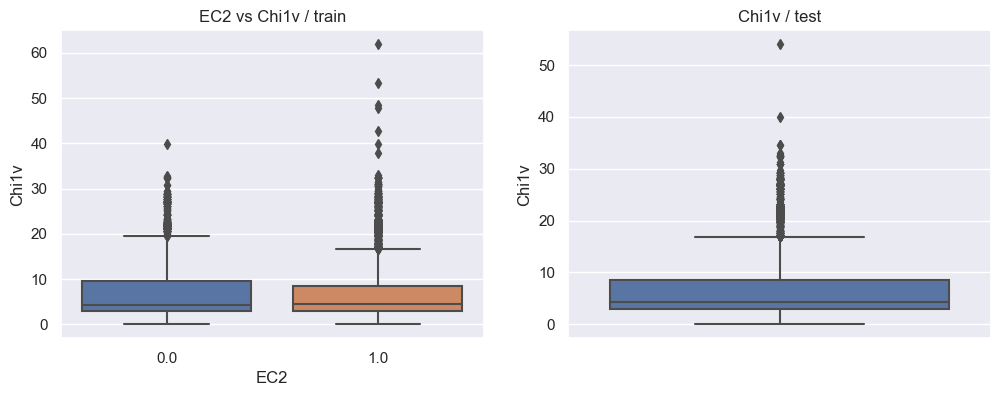

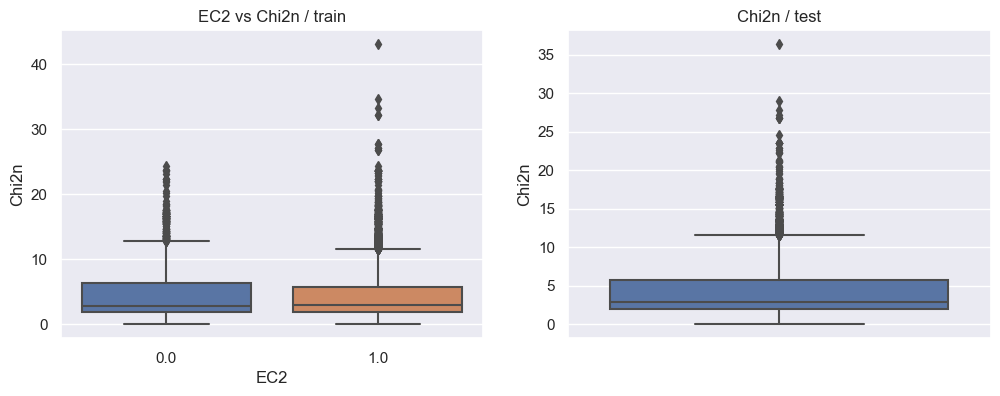

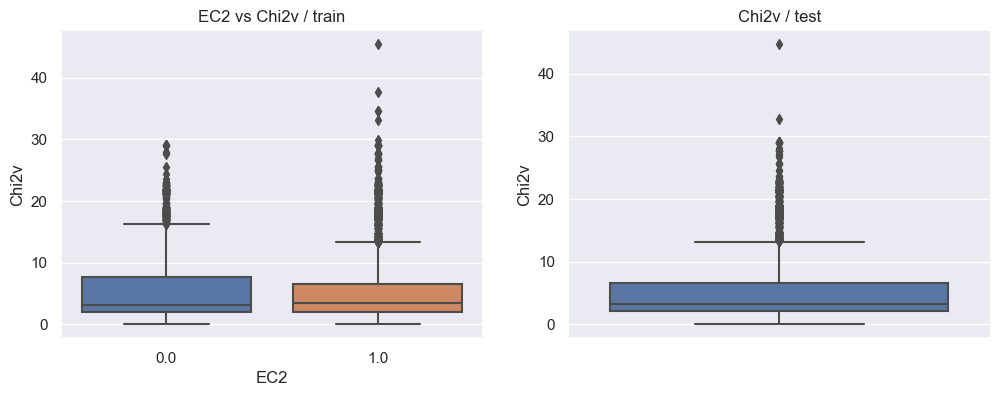

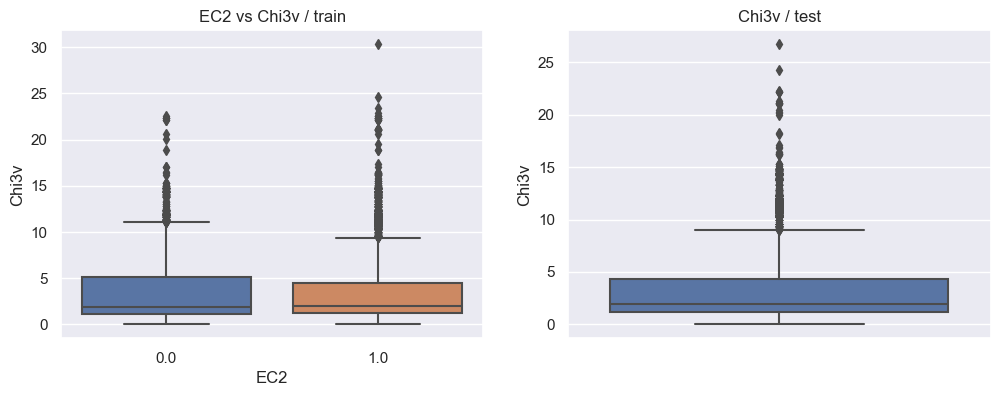

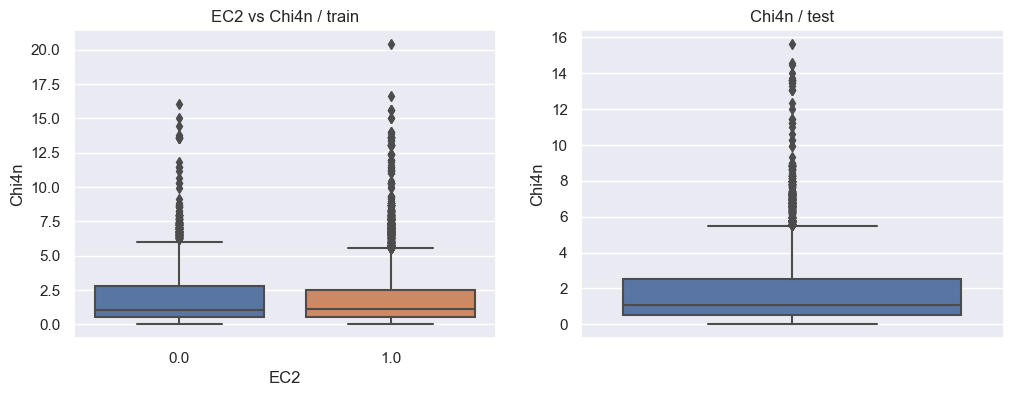

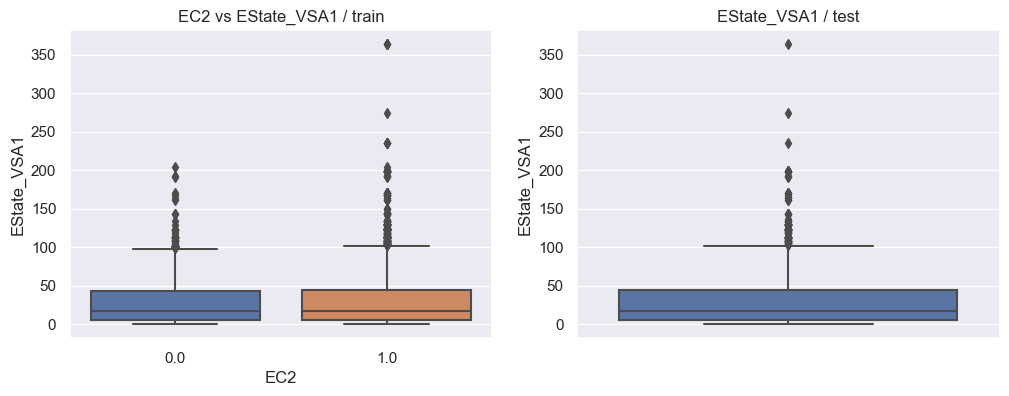

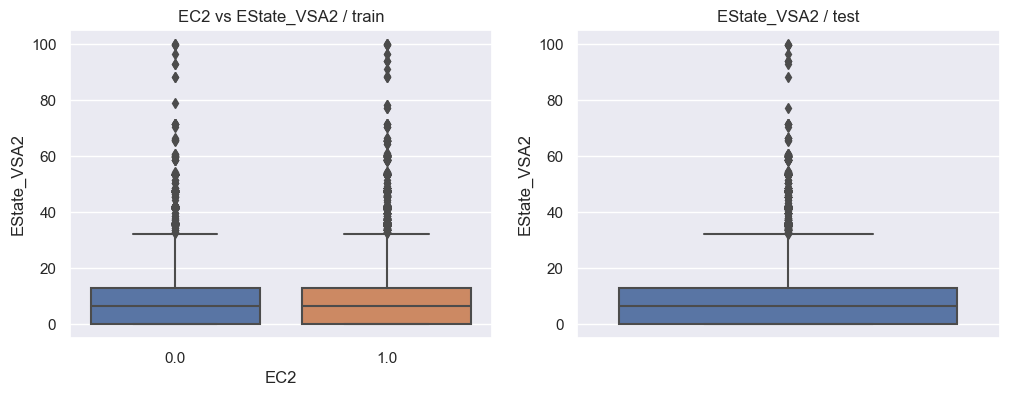

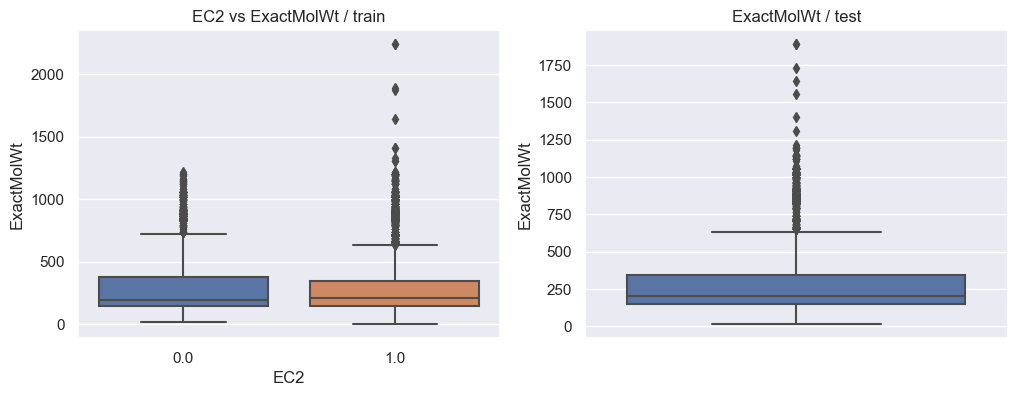

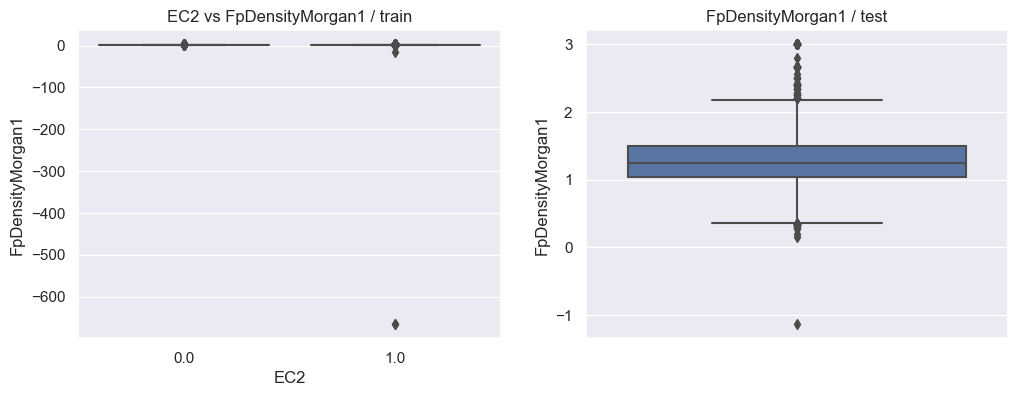

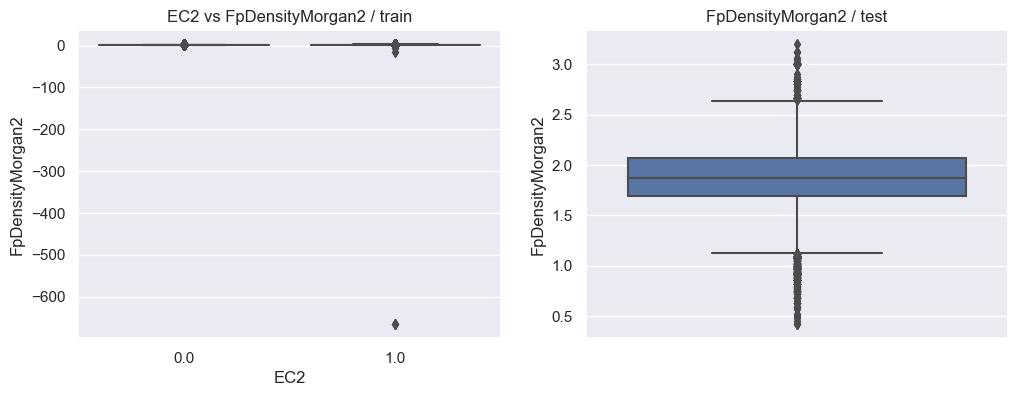

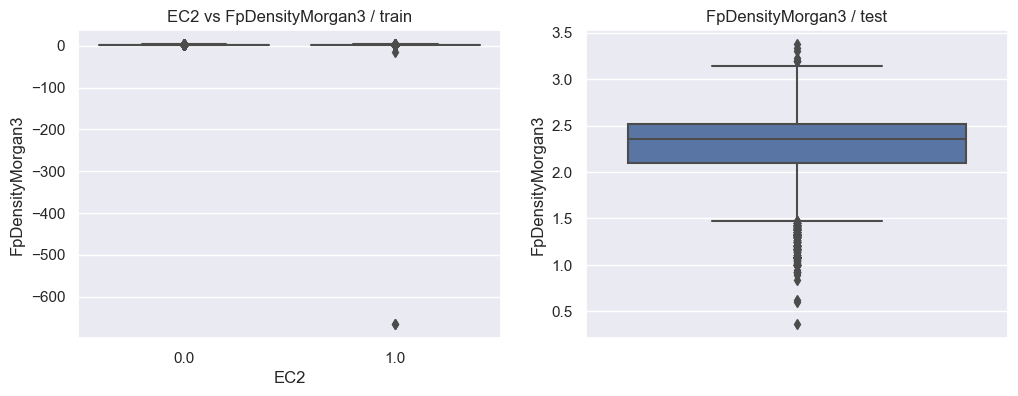

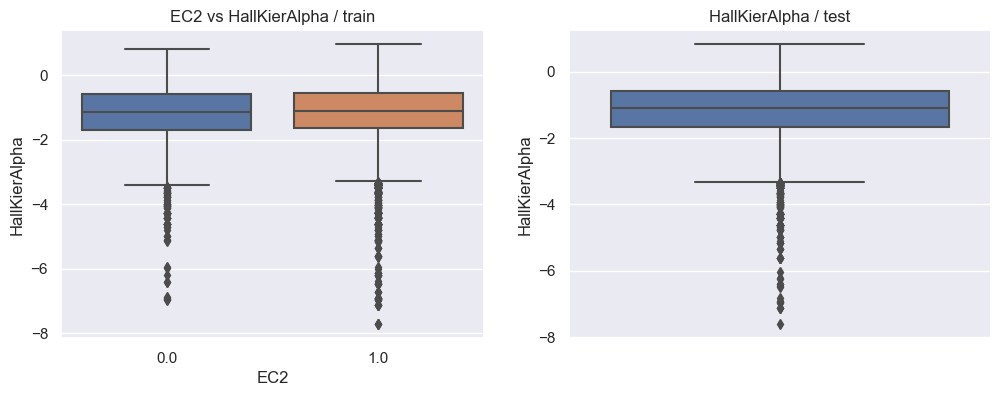

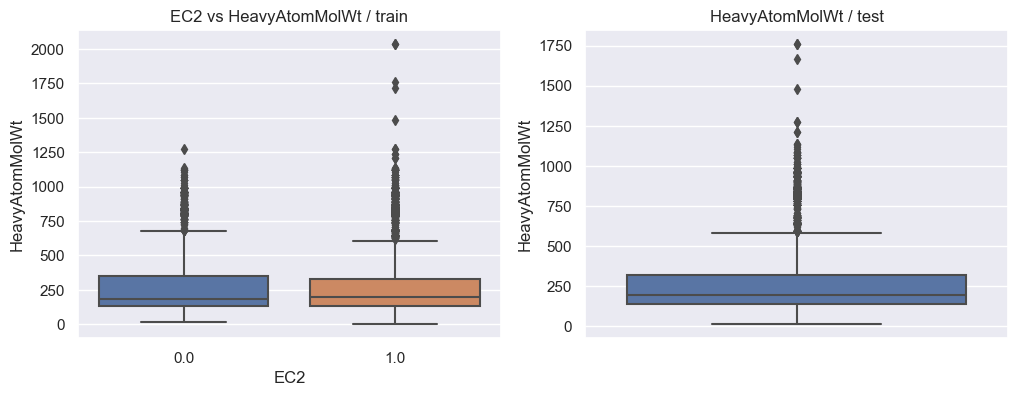

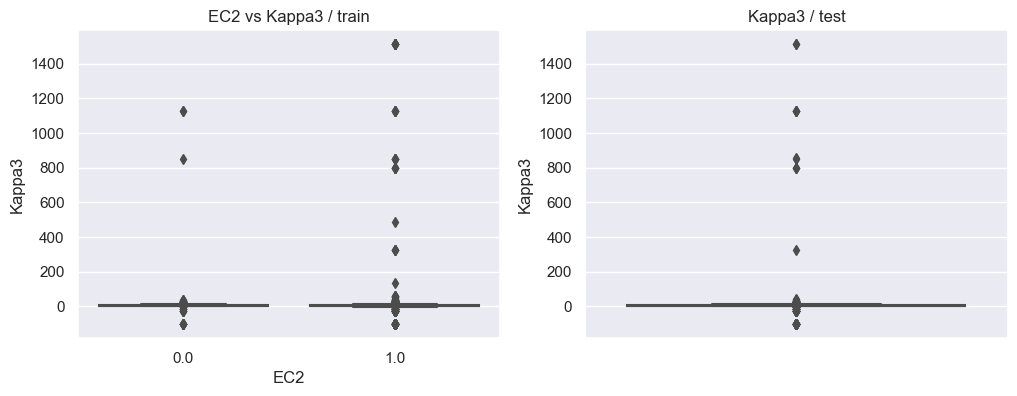

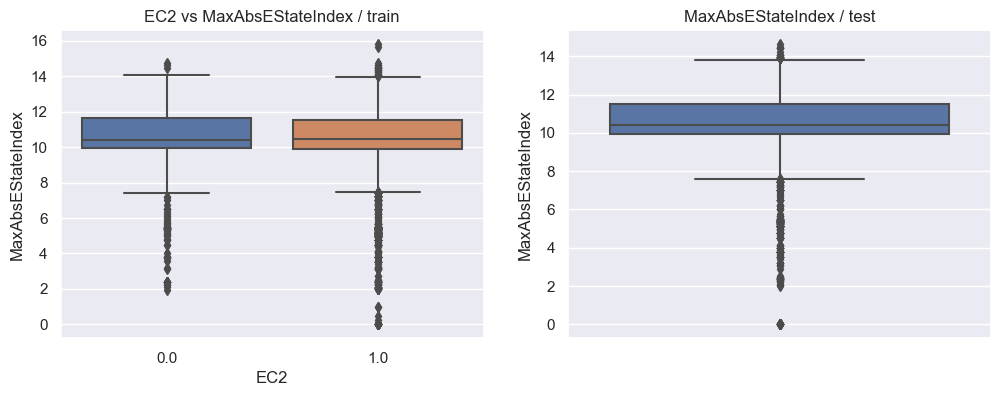

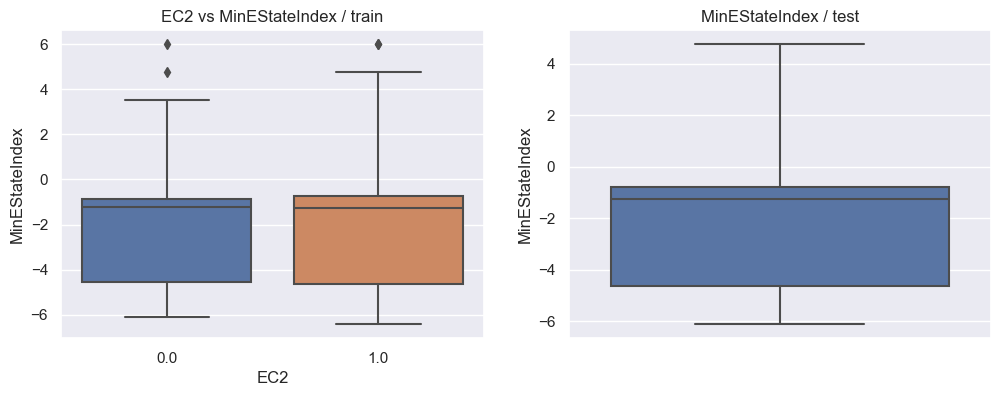

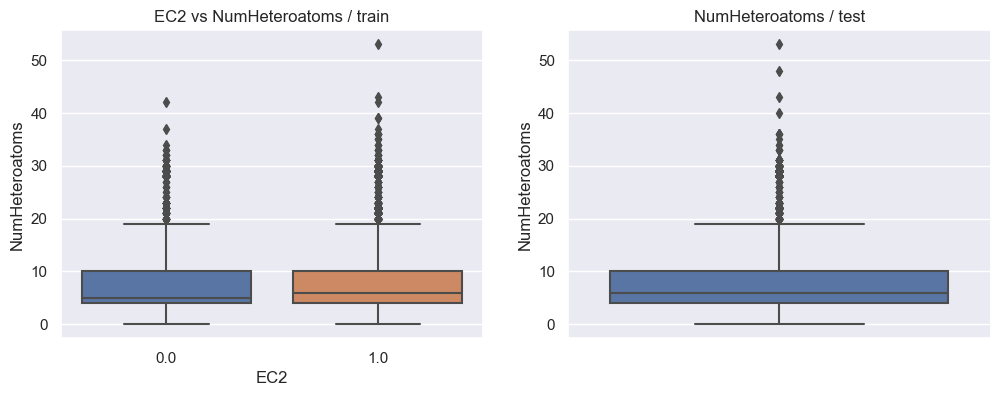

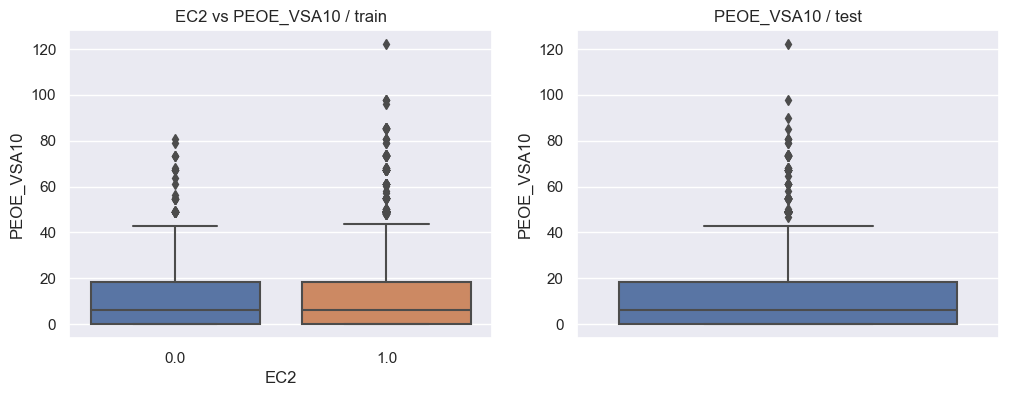

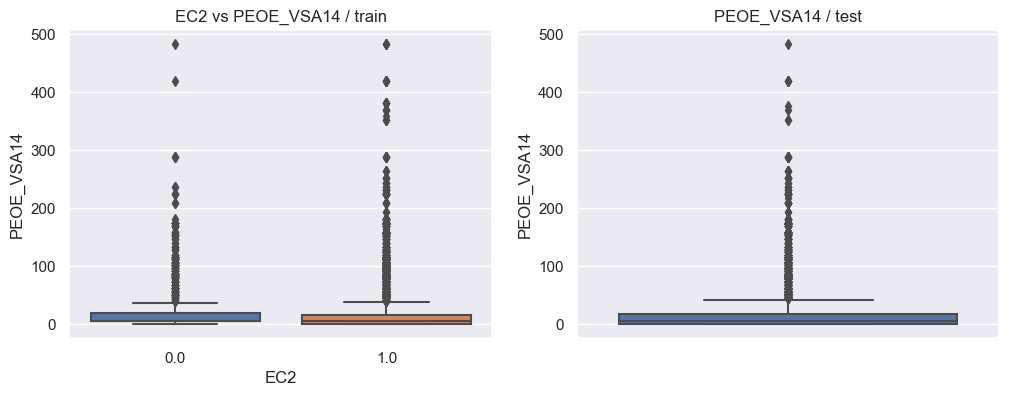

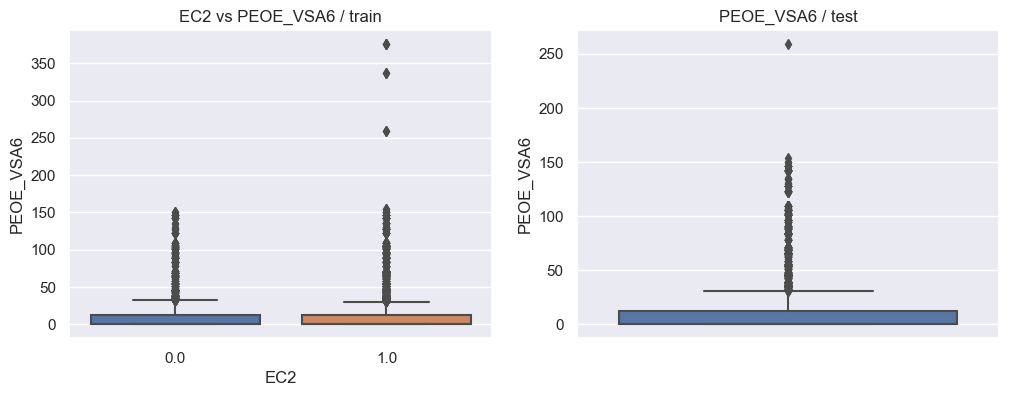

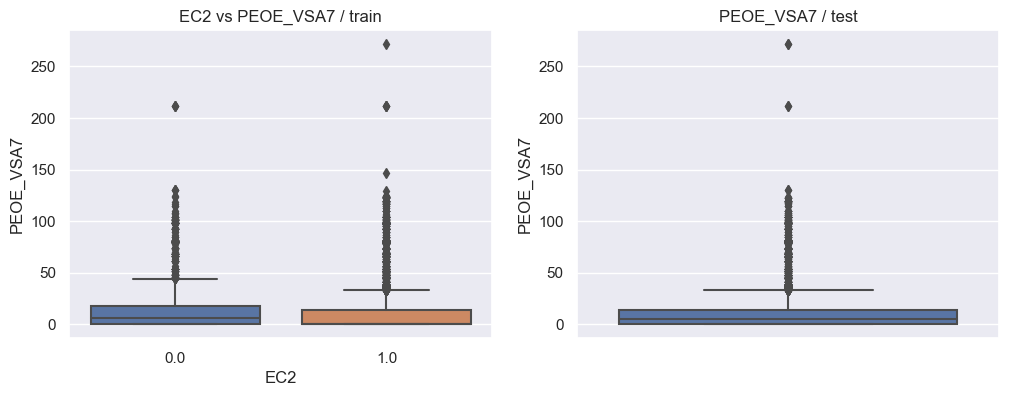

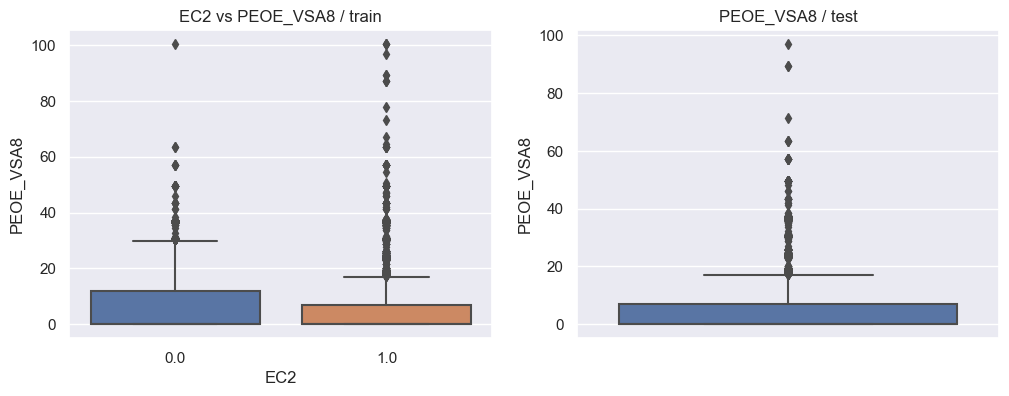

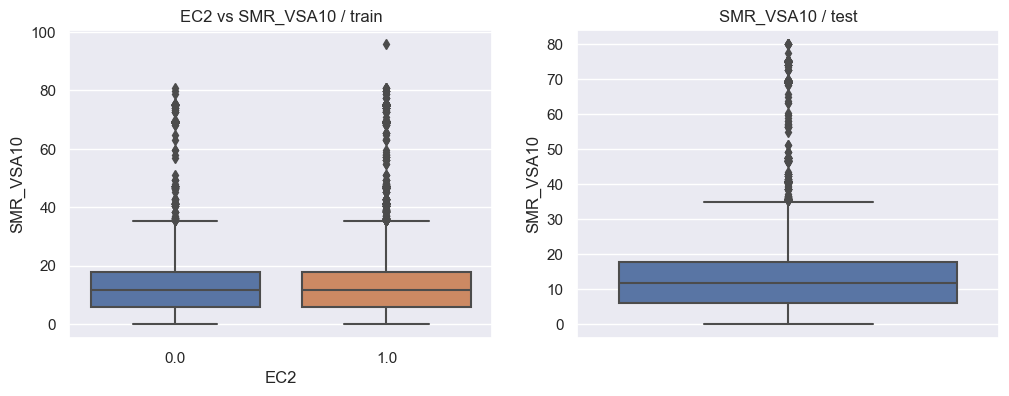

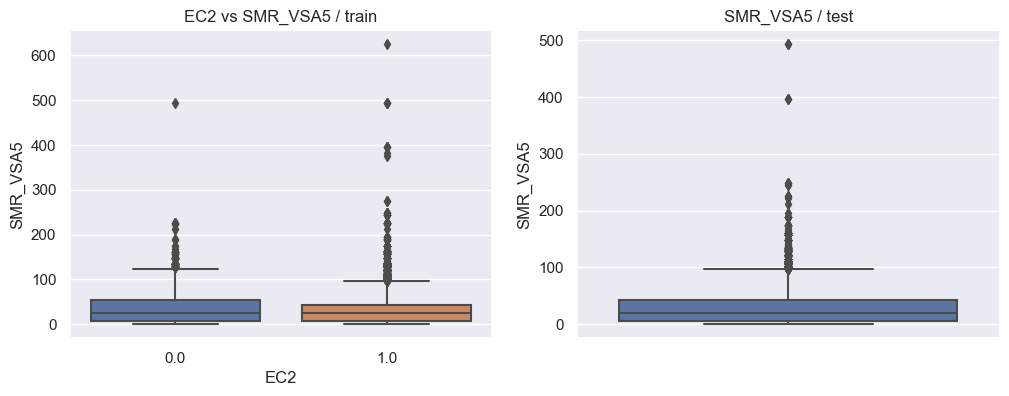

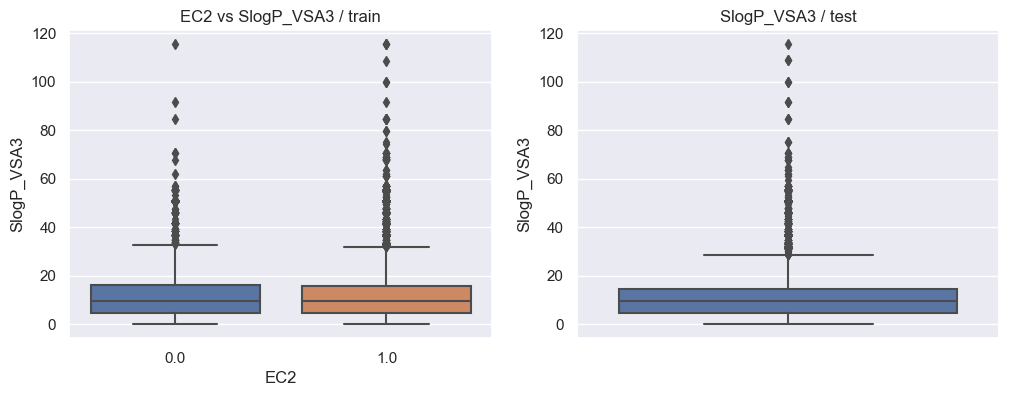

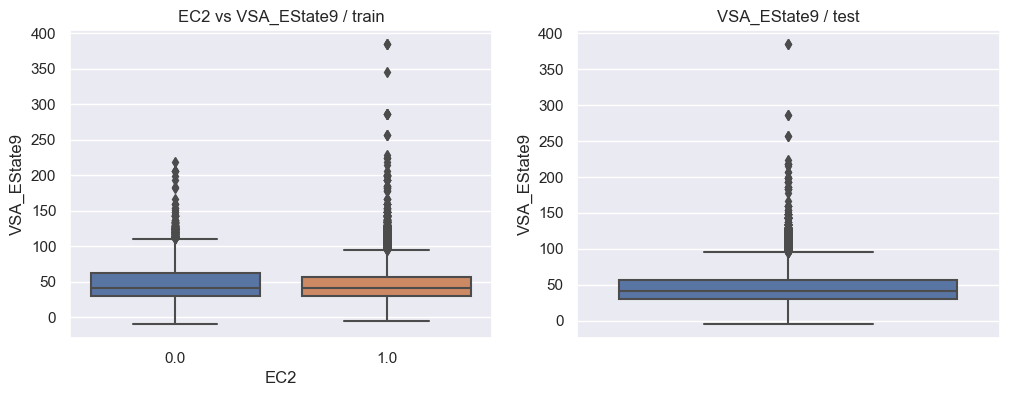

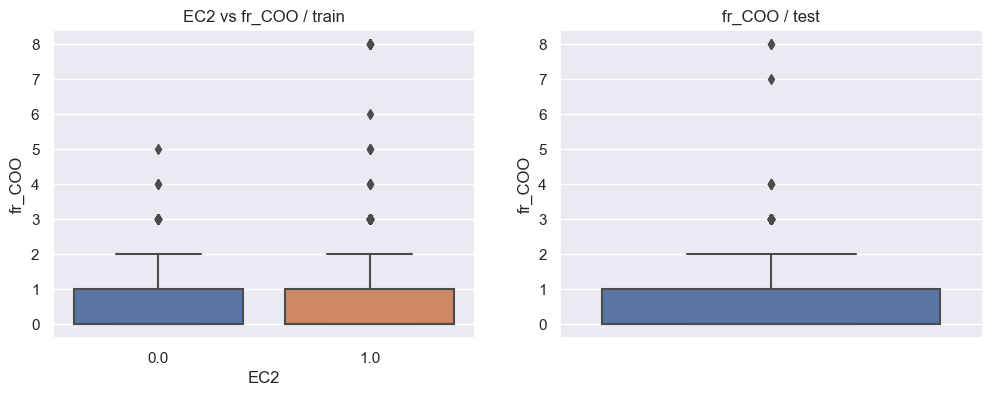

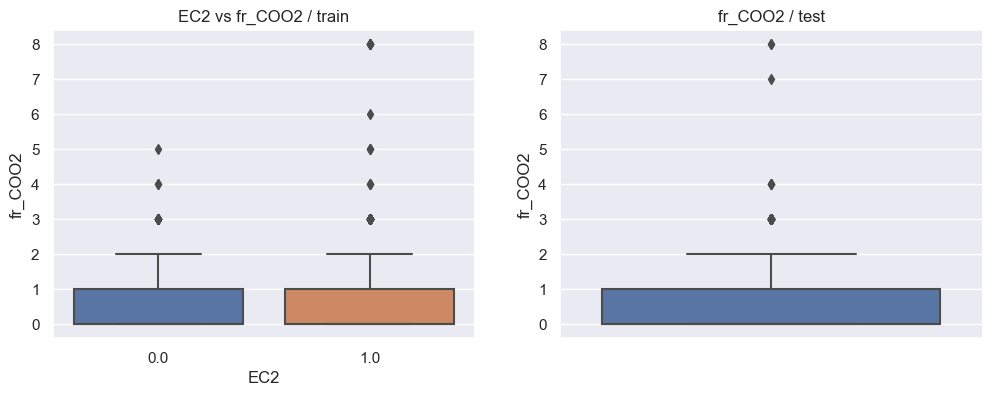

In [39]:
# Plot histograms (train and test)

for feat in feat_ary_2:
    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,2,1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')
    plt.show()

# Visualize distribution of "EC1" and "EC2" in train

plt.figure(figsize=(12,3))
train['EC1'].plot(kind='hist', bins=50, color='green')
plt.title('EC1 / train')
plt.show()

plt.figure(figsize=(12,3))
train['EC2'].plot(kind='hist', bins=50, color='green')
plt.title('EC2 / train')
plt.show()

# Visualize the distributions of data in train and test

for feat in feat_ary_2:
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    sns.boxplot(data=train, x='EC1', y=feat)
    plt.title('EC1 vs ' + feat + ' / train')
    x1 = plt.subplot(1,2,2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()


for feat in feat_ary_2:
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    sns.boxplot(data=train, x='EC2', y=feat)
    plt.title('EC2 vs ' + feat + ' / train')
    x1 = plt.subplot(1,2,2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

In [40]:
# Remove outliers

train = train.drop(train[train['FpDensityMorgan1'] < -100].index)
train = train.drop(train[train['FpDensityMorgan2'] < -100].index)
train = train.drop(train[train['FpDensityMorgan3'] < -100].index)

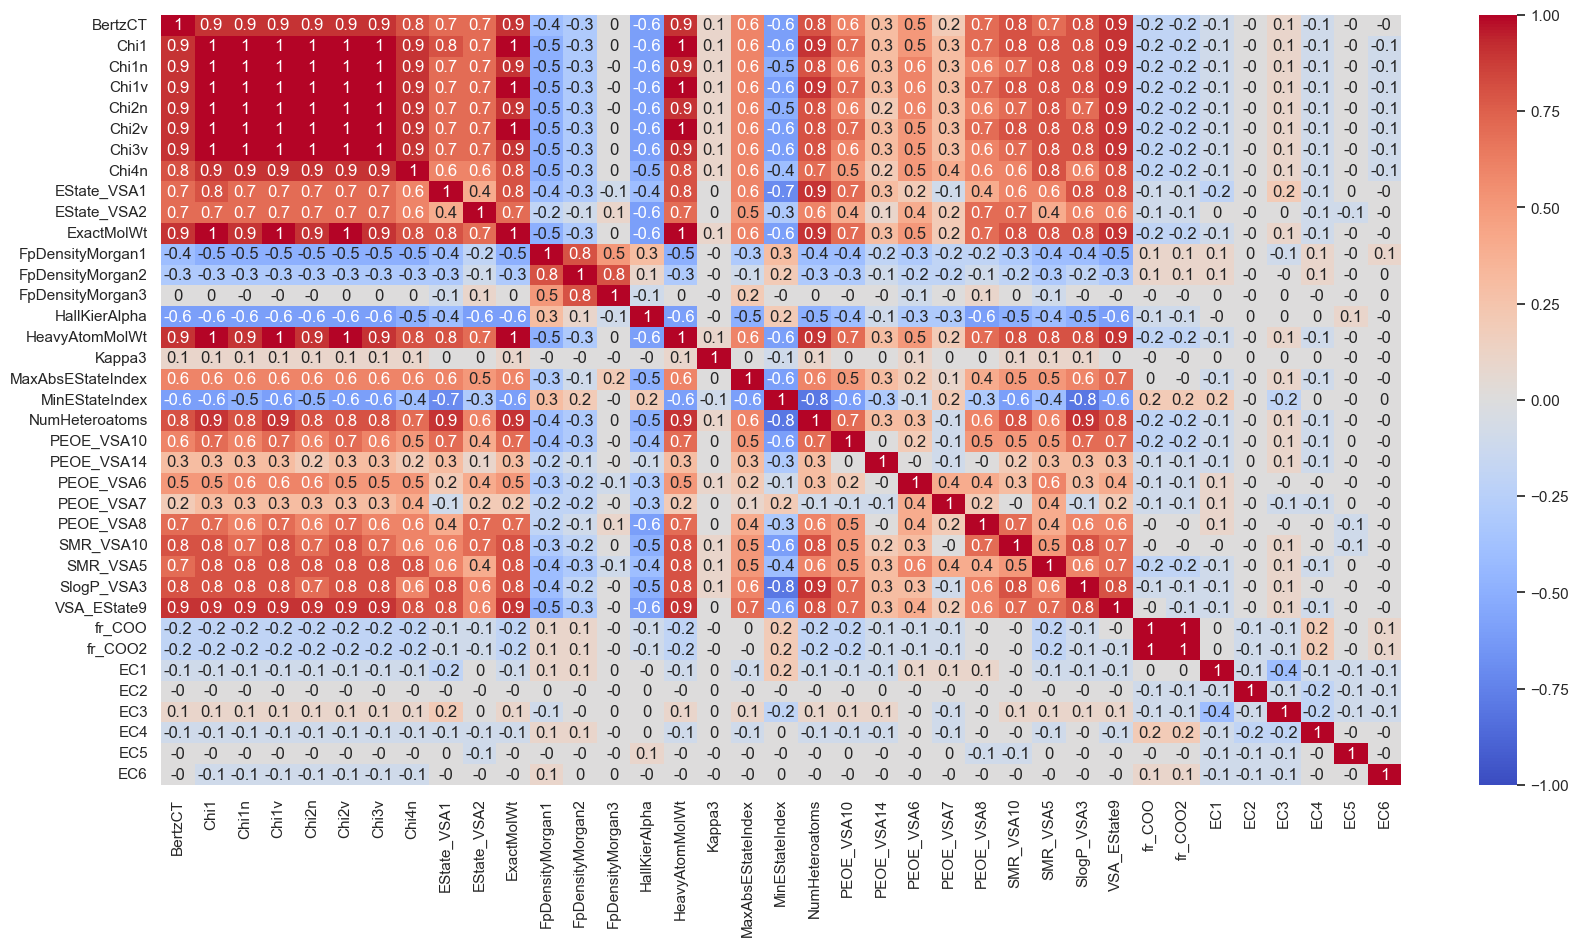

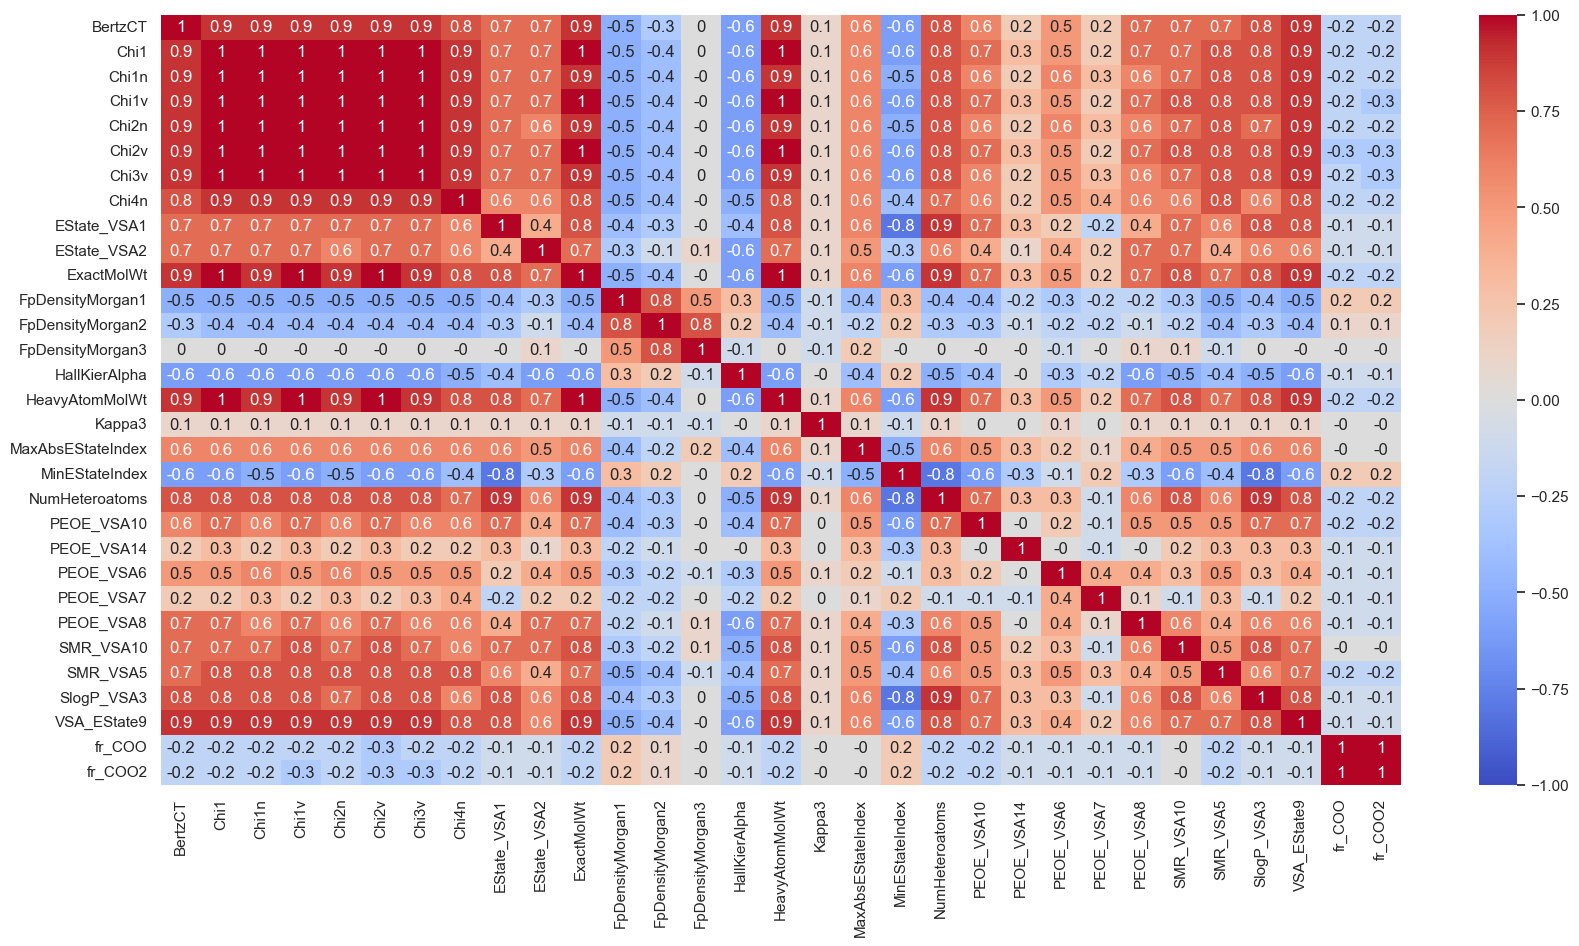

In [41]:
# Heatmap(train)

corr = train.drop(columns=['id']).corr().round(1)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

# Heatmap(test)

corr = test.drop(columns=['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']).corr().round(1)
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

In [42]:

# Modeling
#-------------------------------------------------------
# 【order】
#-------------------------------------------------------
# 1 : EC1とEC2を同時に予測する
# 2 : EC1を予測し、EC1の予測結果も含めたデータを再学習してEC2を予測する
# 1 : Predict EC1 and EC2 at the same time
# 2 : Predict EC1, relearn data including EC1 predictions, and predict EC2

order = 1
optuna_switch = 'off' # 'on' or other
round_opt = 1 # Specify the number of times to run optuna
usingGPU = 'n' # 'y' or other

# params

objective = "binary"
metric = "auc" # binary_logloss, binary_error, auc
test_size = 0.2

# optuna

def tuneParam(X, value, test_size, usingGPU):
    if usingGPU == 'y':
        opt_params = {
            'device': 'gpu',
            "objective" : objective,
            "metric" : metric
        }
    else:
        opt_params = {
            "objective" : objective,
            "metric" : metric
        }

    X_train,X_test,y_train,y_test = train_test_split(
        X,
        value,
        test_size = test_size
    )

    reg_train = lgb.Dataset(
        X_train,
        y_train
    )

    reg_eval = lgb.Dataset(
        X_test,
        y_test,
        reference = reg_train
    )

    opt = lgbo.train(
        opt_params,
        reg_train,
        valid_sets = reg_eval,
        verbose_eval = False,
        num_boost_round = 100,
        early_stopping_rounds = 100
    )
    return opt

In [43]:
target_ary = ['EC1', 'EC2']

X = train[feat_ary_2]

%%time

if optuna_switch == 'on':
    print('【optuna】')
    dict_opt = {}
    for target in target_ary:
        if order == 2 and target == 'EC2':
            X = train[feat_ary_3]
        else:
            X = train[feat_ary_2]
        #value = train[target]
        print('='*40)
        print(f'Target : {target}')
        print('='*40)
        value = train[target]
        opt_ary = []
        for i in range(round_opt):
            print('-'*80)
            print(f'Target : {target} Round {i+1} / {round_opt} Start >>>')
            print('-'*80)
            opt = tuneParam(X, value, test_size, usingGPU)
            score = opt.best_score['valid_0'][metric]
            print('-'*80)
            print(f'Target : {target} Round {i+1} / {round_opt} Result')
            print(f'Score : {score}')
            print(opt.params)
            print('-'*80)
            inner_ary = {'score' : score,
                         'params' : opt.params}
            opt_ary.append(inner_ary)
        dict_opt[target] = opt_ary

UsageError: Line magic function `%%time` not found.


In [44]:
# modeling

def learn_model(X, value, test_size, params):
    learning_rate = 0.003 # 0.003
    num_iterations = 1000000
    max_depth = -1

    X_train, X_test, t_train, t_test = train_test_split(X,
                                                        value,
                                                        test_size=test_size,
                                                        random_state=0)

    lgb_train = lgb.Dataset(X_train, t_train)
    lgb_eval = lgb.Dataset(X_test, t_test, reference=lgb_train)

    if usingGPU == 'y':
        device = 'gpu'
    else:
        device = ''

    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'feature_pre_filter': params['feature_pre_filter'],
        'lambda_l1': params['lambda_l1'],
        'lambda_l2': params['lambda_l2'],
        'num_leaves': params['num_leaves'],
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'min_child_samples': params['min_child_samples'],
        'verbosity': -1
    }

    evaluation_results = {}                       # 学習の経過を保存する
    model = lgb.train(
        params,
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        train_set=lgb_train,
        early_stopping_rounds=100,#100
        verbose_eval=100
    )
    
    model_ary = {'evaluation_results' : evaluation_results, 'model' : model}
    return model_ary

In [45]:
# Specify parameters without using optuna

if optuna_switch != 'on':
    dict_opt = {
        'EC1':[
#3
#EC1
#auc : 0.7436242683434713
{'score': 0.7114333209868448, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.1313624992161823e-08, 'lambda_l2': 2.6903269221780956e-05, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.404975329739762, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}},
#1
#EC1
#auc : 0.74742338863484
{'score': 0.721824618637941, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 33, 'feature_fraction': 0.7, 'bagging_fraction': 0.8811383554681678, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}},
#5
#EC1
#auc : 0.7299475051291746
{'score': 0.7117767184093715, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 11, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}}#,
#17
#EC1
#auc : 0.7385756722147235
#{'score': 0.727885929764564, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 3.417690181589809e-05, 'lambda_l2': 0.010841537517890654, 'num_leaves': 28, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}}
        ],'EC2':[
#1
#EC2
#auc : 0.5973999936778798
{'score': 0.5951522991346448, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 4.6588302514769984e-07, 'lambda_l2': 3.3438267067923944, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.7254126647599951, 'bagging_freq': 4, 'min_child_samples': 25, 'num_iterations': 100, 'early_stopping_round': 100}},
#2
#EC2
#auc : 0.6010220090284589
{'score': 0.6165134378664019, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0002510897115006619, 'lambda_l2': 0.007553492459815822, 'num_leaves': 6, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}},
#3
#EC2
#auc : 0.6250384456576458
{'score': 0.6022105811623725, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.0498078583030938e-08, 'lambda_l2': 0.0037003812379673203, 'num_leaves': 8, 'feature_fraction': 0.9520000000000001, 'bagging_fraction': 0.4213062232854844, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}},
#6
#EC2
#auc: 0.599573283878122
{'score': 0.6162527139183592, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 5, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.9933463724870681, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}}
        ]}

In [46]:
%%time

dict_model = {}
for target in target_ary:
    if order == 2 and target == 'EC2':
        X = train[feat_ary_3]
    else:
        X = train[feat_ary_2]
    opt_ary = dict_opt[target]
    value = train[target]
    print()
    print()
    print(f'=====【Target : {target}】=====')
    model_ary = []
    for i in range(len(opt_ary)):
        opt_score = opt_ary[i]['score']
        params = opt_ary[i]['params']
        print()
        print('-'*80)
        print(f'Round {i+1} / {len(opt_ary)}')
        print(f'optuna score : {opt_score}')
        print('-'*80)
        inner_ary = learn_model(X, value, test_size, params)
        model_ary.append(inner_ary)
    dict_model[target] = model_ary



=====【Target : EC1】=====

--------------------------------------------------------------------------------
Round 1 / 3
optuna score : 0.7114333209868448
--------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.74617	valid's auc: 0.721775
[200]	train's auc: 0.751199	valid's auc: 0.721598
Early stopping, best iteration is:
[147]	train's auc: 0.748918	valid's auc: 0.722353

--------------------------------------------------------------------------------
Round 2 / 3
optuna score : 0.721824618637941
--------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.748338	valid's auc: 0.721131
[200]	train's auc: 0.753828	valid's auc: 0.721736
[300]	train's auc: 0.75932	valid's auc: 0.721679
Early stopping, best iteration is:
[200]	train's auc: 0.753828	valid's auc: 0.721736

-------------

EC1
--------------------------------------------------------------------------------
Round 1 / 3
optuna score : 0.7114333209868448
valid score : 0.7223532668510668
--------------------------------------------------------------------------------


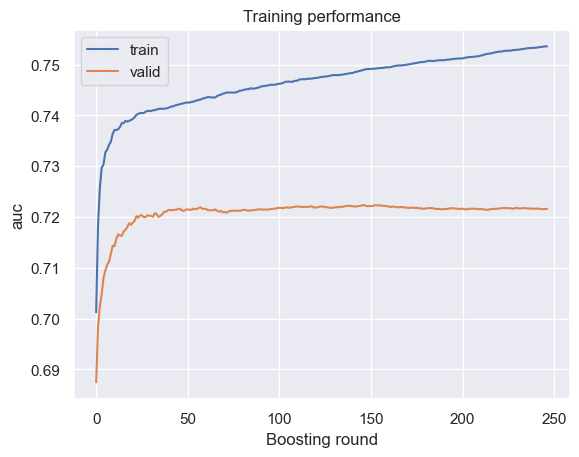

--------------------------------------------------------------------------------
Round 2 / 3
optuna score : 0.721824618637941
valid score : 0.7217355488135662
--------------------------------------------------------------------------------


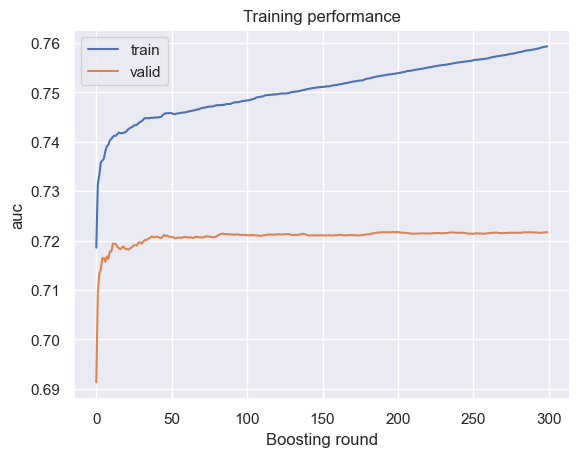

--------------------------------------------------------------------------------
Round 3 / 3
optuna score : 0.7117767184093715
valid score : 0.7216531715255872
--------------------------------------------------------------------------------


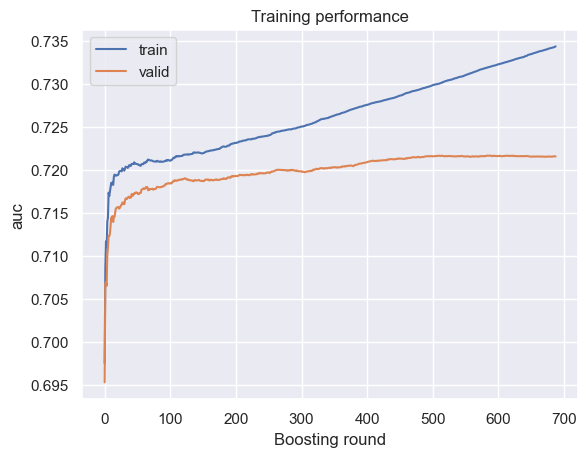

EC2
--------------------------------------------------------------------------------
Round 1 / 4
optuna score : 0.5951522991346448
valid score : 0.5893374817160014
--------------------------------------------------------------------------------


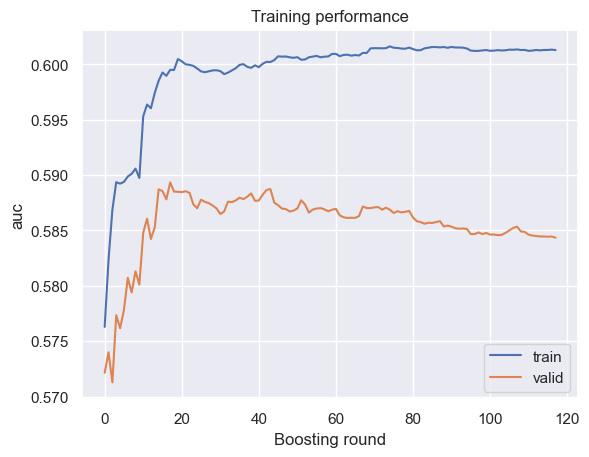

--------------------------------------------------------------------------------
Round 2 / 4
optuna score : 0.6165134378664019
valid score : 0.5923519356980638
--------------------------------------------------------------------------------


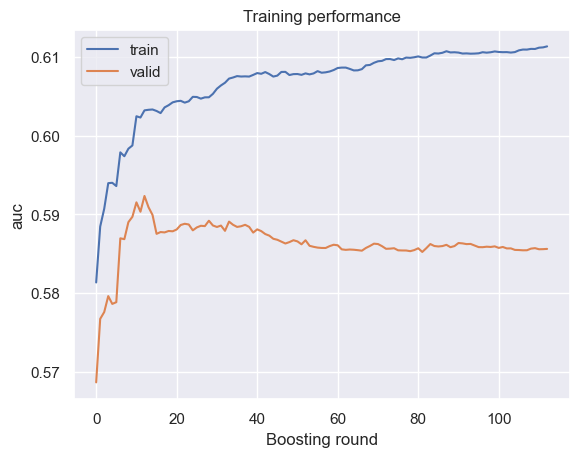

--------------------------------------------------------------------------------
Round 3 / 4
optuna score : 0.6022105811623725
valid score : 0.5891119389699373
--------------------------------------------------------------------------------


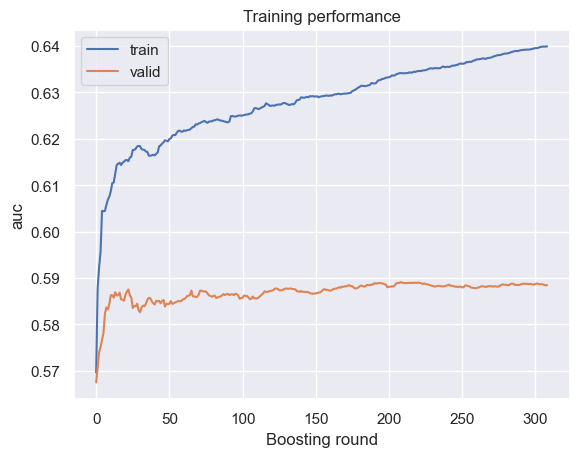

--------------------------------------------------------------------------------
Round 4 / 4
optuna score : 0.6162527139183592
valid score : 0.589692636360137
--------------------------------------------------------------------------------


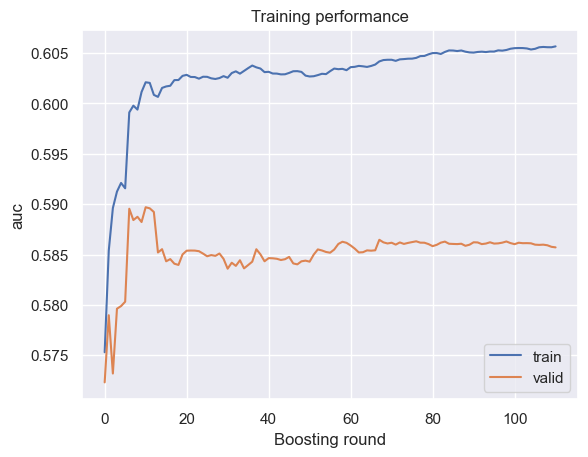

UsageError: Line magic function `%%time` not found.


In [47]:
# Learning progress

def show_train_result(evaluation_results):
    plt.plot(evaluation_results['train'][metric], label='train')
    plt.plot(evaluation_results['valid'][metric], label='valid')
    plt.ylabel(metric)
    plt.xlabel('Boosting round')
    plt.title('Training performance')
    plt.legend()
    plt.show()

for target in target_ary:
    print(target)
    model_ary = dict_model[target]
    opt_ary = dict_opt[target]
    for i in range(len(model_ary)):
        print('-'*80)
        print(f'Round {i+1} / {len(model_ary)}')
        opt_score = opt_ary[i]['score']
        print(f'optuna score : {opt_score}')
        model = model_ary[i]['model']
        val_score = model.best_score['valid'][metric]
        print(f'valid score : {val_score}')
        print('-'*80)
        evaluation_results = model_ary[i]['evaluation_results']
        show_train_result(evaluation_results)

# Roc Curve

def show_roc_curve(X, model, target):
    for_verifi = model.predict(X)
    true = train[target]
    fpr, tpr, thresholds = roc_curve(true, for_verifi)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.title('ROC Curve')
    plt.show()
    
    return {'for_verifi' : for_verifi,
            'fpr' : fpr,
            'tpr' : tpr}

# Confusion matrix

def show_cm(for_verifi, target):
    cm = confusion_matrix(train[target], np.round(for_verifi))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.show()


%%time

for target in target_ary:
    if order == 2 and target == 'EC2':
        X = train[feat_ary_3]
    else:
        X = train[feat_ary_2]
    model_ary = dict_model[target]
    print('='*40)
    print(f'【Target : {target}】')
    print('='*40)
    for i in range(len(model_ary)):
        print('-'*80)
        print(f'Round {i+1} / {len(model_ary)}')
        model = model_ary[i]['model']
        val_score = model.best_score['valid'][metric]
        print(f'Valid Score : {val_score}')
        print('-'*80)

        # Rock curve
        obj = show_roc_curve(X, model, target)

        # Auc
        fpr = obj['fpr']
        tpr = obj['tpr']
#        print(f'fpr:{fpr},tpr{tpr}')
        acc = auc(fpr, tpr)
        model_ary[i]['auc'] = acc
        print(f'auc : {acc}')
        print()

        # Confusion Matrix
        print('Confusion Matrix')
        for_verify = obj['for_verifi']
        show_cm(for_verify, target)


# Feature importance

print("【Feature Importance of EC2】")

fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(model, ax=ax)



In [48]:
# sudha skipped verification steps with roc and graphs
# predict
def get_pred(test, target, feat_ary):
    dict_fold = {}
    model_ary = dict_model[target]
    opt_ary = dict_opt[target]
    fold = []
    print()
    for i in range(len(model_ary)):
        model = model_ary[i]['model']
        auc = model_ary[i]['auc']
        if auc > 0.5:
            print(f'#{target}<br>')
            print(f'#auc : {auc}<br>')
            print(f'{opt_ary[i]}<br>')
            print()
            result = model.predict(test[feat_ary])
            fold.append(result)
    dict_fold[target] = fold
    print('-'*80)
    print(f'Result : {fold}')
    print('-'*80)
    return dict_fold

In [49]:
print('='*40)
print('【Selected optuna params and results】')
print('='*40)
dict_target = {}
for target in target_ary:
    if order == 2 and target == 'EC2':
        feat_ary = feat_ary_3
    else:
        feat_ary = feat_ary_2
    dict_fold = get_pred(test, target, feat_ary)

    # 複数のモデルで予測した結果をアンサンブル
    # Ensemble predicted results
    fold = dict_fold[target]
    if len(fold) > 0:
        df_result = pd.DataFrame(fold).transpose().mean(axis=1)
        dict_target[target] = df_result
        
        if order == 2 and target == 'EC1':
            # EC1の予測結果を含めて再学習
            # Relearn including EC1 prediction results
            test[target] = np.array(df_result)
    else:
        print('No result')

【Selected optuna params and results】



KeyError: 'auc'

In [ ]:
for target in target_ary:
    df_result = dict_target[target]
    sample_submission[target] = df_result
sample_submission

sample_submission.to_csv('submission.csv', index=False)
